In [1]:
pkgs <- c("DBI", "RSQLite", "reshape2", "ggplot2", "gridExtra",
          "data.table", "gridBase", "grid", "scales", 'dplyr', 'knitr', 'kableExtra','data.table', 'tidyr') 
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages()))) { install.packages(pkg) }
  require(pkg, character.only = TRUE)
}

Loading required package: DBI

Loading required package: RSQLite

Loading required package: reshape2

Loading required package: ggplot2

Loading required package: gridExtra

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


Loading required package: gridBase

Loading required package: grid

Loading required package: scales

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: knitr

Loading required package: kableExtra


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loa

# Top 10 country

In [2]:
# Read the data
country_eng <- read.csv('/kaggle/input/data-hihi/country_eng.csv')
custom <- read.csv('/kaggle/input/data-hihi/custom.csv')
exp_custom_latest_ym <- read.csv('/kaggle/input/data-hihi/ym_custom_latest.csv')

In [3]:
figure_width <- 15  # Adjust the width as desired
figure_height <- 10  # Adjust the height as desired

# Modify the graphics device settings
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

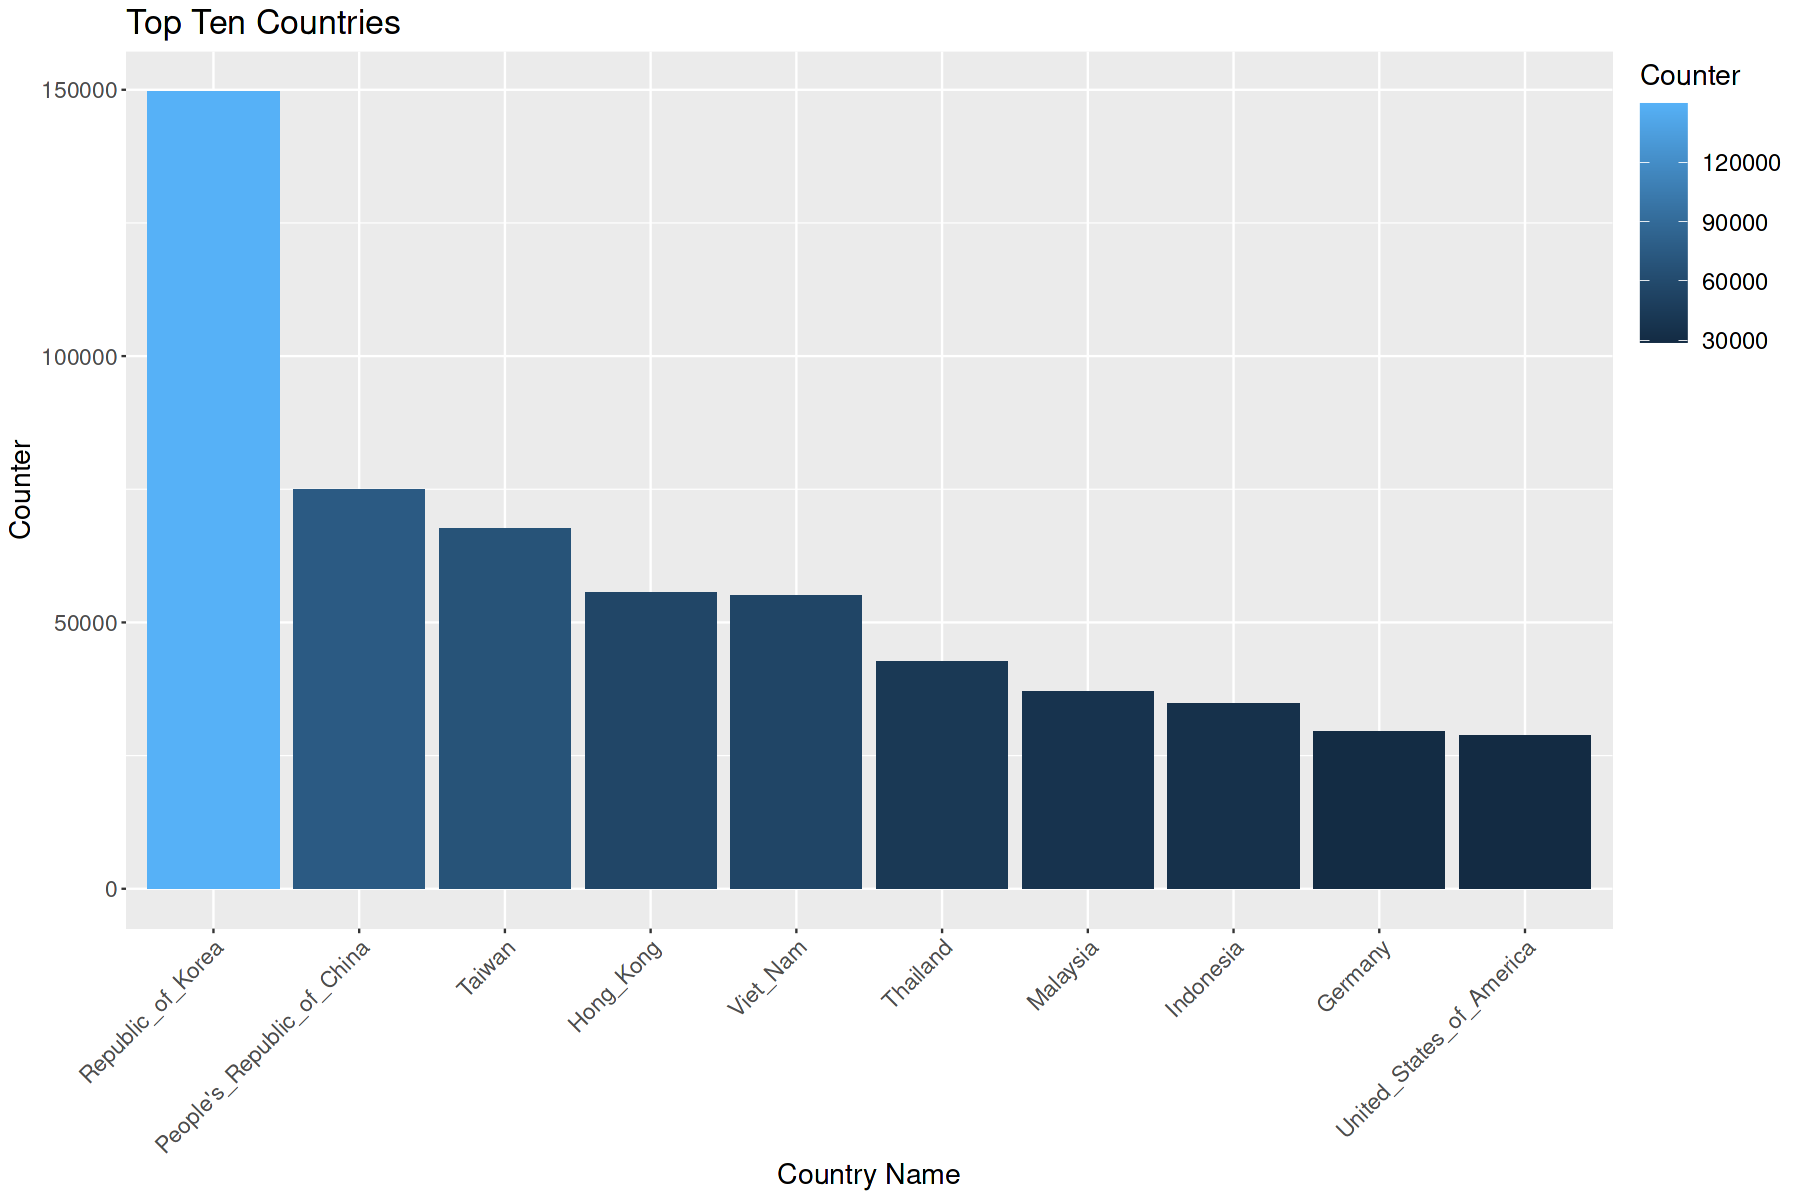

In [7]:
# Filter data for the year 2017
country_year <- exp_custom_latest_ym[exp_custom_latest_ym$Year == 2017, ]
# Calculate the count for each country
table_counter <- country_year %>%
  count(Country) %>%
  top_n(10, wt = n) %>%
  arrange(desc(n))

# Extract the country names
table_index <- table_counter$Country

# Convert table_index to country names
table_index <- country_eng$Country_name[country_eng$Country %in% table_index]

# Convert table_counter to a vector
table_values <- table_counter$n

# Create the plot
plot_data <- data.frame(Country = table_index, Counter = table_values)
plot_data <- plot_data[order(-plot_data$Counter), ]  # Sort the data frame in descending order of Counter

plot <- ggplot(plot_data, aes(x = reorder(Country, -Counter), y = Counter, fill = Counter)) +
  geom_bar(stat = "identity") +
  labs(title = "Top Ten Countries", x = "Country Name", y = "Counter") +
  theme(text = element_text(size = 16.75),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
        legend.justification = c(0, 1),
        legend.key.size = unit(2, "lines"),
        legend.text = element_text(size = 14))

# Display the plot
print(plot)

In [22]:
tryCatch({
  db <- dbConnect(drv = SQLite(), 
                dbname = "/kaggle/input/data-hihi/year_1988_2015.db")
  X <- as.data.table(dbReadTable(db, "year_1988_2015"))
}, error = function (e) {
  print(e)
}, finally = {
  if(exists("db")) {
    dbDisconnect(db)
    rm (db)
  }
})

X[, Value := as.numeric(VY)]
X[, Q1 := as.numeric(QY1)]
X[, Q2 := as.numeric(QY2)]

X[, VY := NULL]
X[, QY1 := NULL]
X[, QY2 := NULL] 

X[, index := NULL] 

for (yr in c(as.character(2016), "latest")) {
  tryCatch({
    db <- dbConnect(
      drv = SQLite(), 
      dbname = file.path("/kaggle/input/data-hihi", paste0("ym_custom_", yr, ".db")))
    
    dt <- as.data.table(dbReadTable(db, paste0("ym_custom_", yr)))
    dt[, Custom := NULL]
    
    dt[, Value := as.numeric(Value)]
    dt[, Q1 := as.numeric(Q1)]
    dt[, Q2 := as.numeric(Q2)]
    
    # the aggregate function, although arguably more readable, is 
    # unreasonably slow here; hence the reliance on data.table
    dt <- dt[,  
              .(Value = mean(Value)), 
              by = setdiff(names(dt), c("Value", "index", "month"))]
    
    dt <- dt[, 
              .(Value = sum(Value), Q1 = sum(Q1), Q2 = sum(Q2)), 
              by = setdiff(names(dt), c("Value", "Q1", "Q2"))]
    
    X <- rbind(X, dt)
    
    rm(dt)
  }, error = function (e) {
    print(e)
  }, finally = {
    if(exists("db")) {
      dbDisconnect(db)
      rm (db)
    }
  })
}
gc()

hs2 <- fread(file.path("/kaggle/input/data-hihi/hs2_eng.csv"), header = TRUE, 
                  data.table = TRUE, na.strings=c("NA", "?", ""))

hs4 <- fread(file.path("/kaggle/input/data-hihi/hs4_eng.csv"), header = TRUE, 
                  data.table = TRUE, na.strings=c("NA", "?", ""))

hs6 <- fread(file.path("/kaggle/input/data-hihi/hs6_eng.csv"), header = TRUE, 
                  data.table = TRUE, na.strings=c("NA", "?", ""))

hs9 <- fread(file.path("/kaggle/input/data-hihi/hs9_eng.csv"), header = TRUE, 
                  data.table = TRUE, na.strings=c("NA", "?", ""))

countries <- fread(file.path("/kaggle/input/data-hihi/country_eng.csv"), header = TRUE, 
                  data.table = TRUE, na.strings=c("NA", "?", ""))




,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1598692,85.4,4793543,256.1,6863850,366.6
Vcells,121715422,928.7,344087083,2625.2,358336357,2733.9


In [23]:
X[, Country := as.character(Country)]
countries[, Country := as.character(Country)]

X <- merge(X, countries, by = "Country")
X[, hs2 := as.numeric(hs2)]
X[, hs4 := as.numeric(hs4)]
X[, hs6 := as.numeric(hs6)]
X[, hs9 := as.numeric(hs9)]

X <- merge(X, hs2, by = "hs2", all.x = TRUE)
X <- merge(X, hs4, by = "hs4", all.x = TRUE)
X <- merge(X, hs6, by = "hs6", all.x = TRUE)
X <- merge(X, hs9, by = "hs9", all.x = TRUE)

X[, Value := as.numeric(Value)]
X[, Q1 := as.numeric(Q1)]
X[, Q2 := as.numeric(Q2)]

X[, Country := NULL]

rm (hs2, hs4, hs6, hs9, countries, yr)
gc()

# Initially, the unit of Value is 1,000 Yen. 
# For readibality, with set it to 1,000,000 Yen.
kYenFactor <- 1000000
X[, Value := Value / 1000]

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1571883,84.0,4793543,256.1,6863850,366.6
Vcells,142545887,1087.6,412984499,3150.9,412650119,3148.3


In [26]:
head(X,20)

hs9,hs6,hs4,hs2,exp_imp,Year,Unit1,Unit2,Value,Q1,Q2,Country_name,Area,hs2_name,hs4_name,hs6_name,hs9_name
<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
11,0,0,0,2,1988,NA,KG,0.458,0,231,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1989,NA,KG,0.957,0,1400,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1990,NA,KG,5.196,0,1800,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1991,NA,KG,8.179,0,13896,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1992,NA,KG,7.186,0,16107,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1993,NA,KG,3.270,0,13514,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1994,NA,KG,4.184,0,31456,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1995,NA,KG,3.673,0,40064,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc
11,0,0,0,2,1996,NA,KG,3.235,0,24927,Republic_of_Korea,Asia,NA,unknow,Unknown,airplain_meal_etc


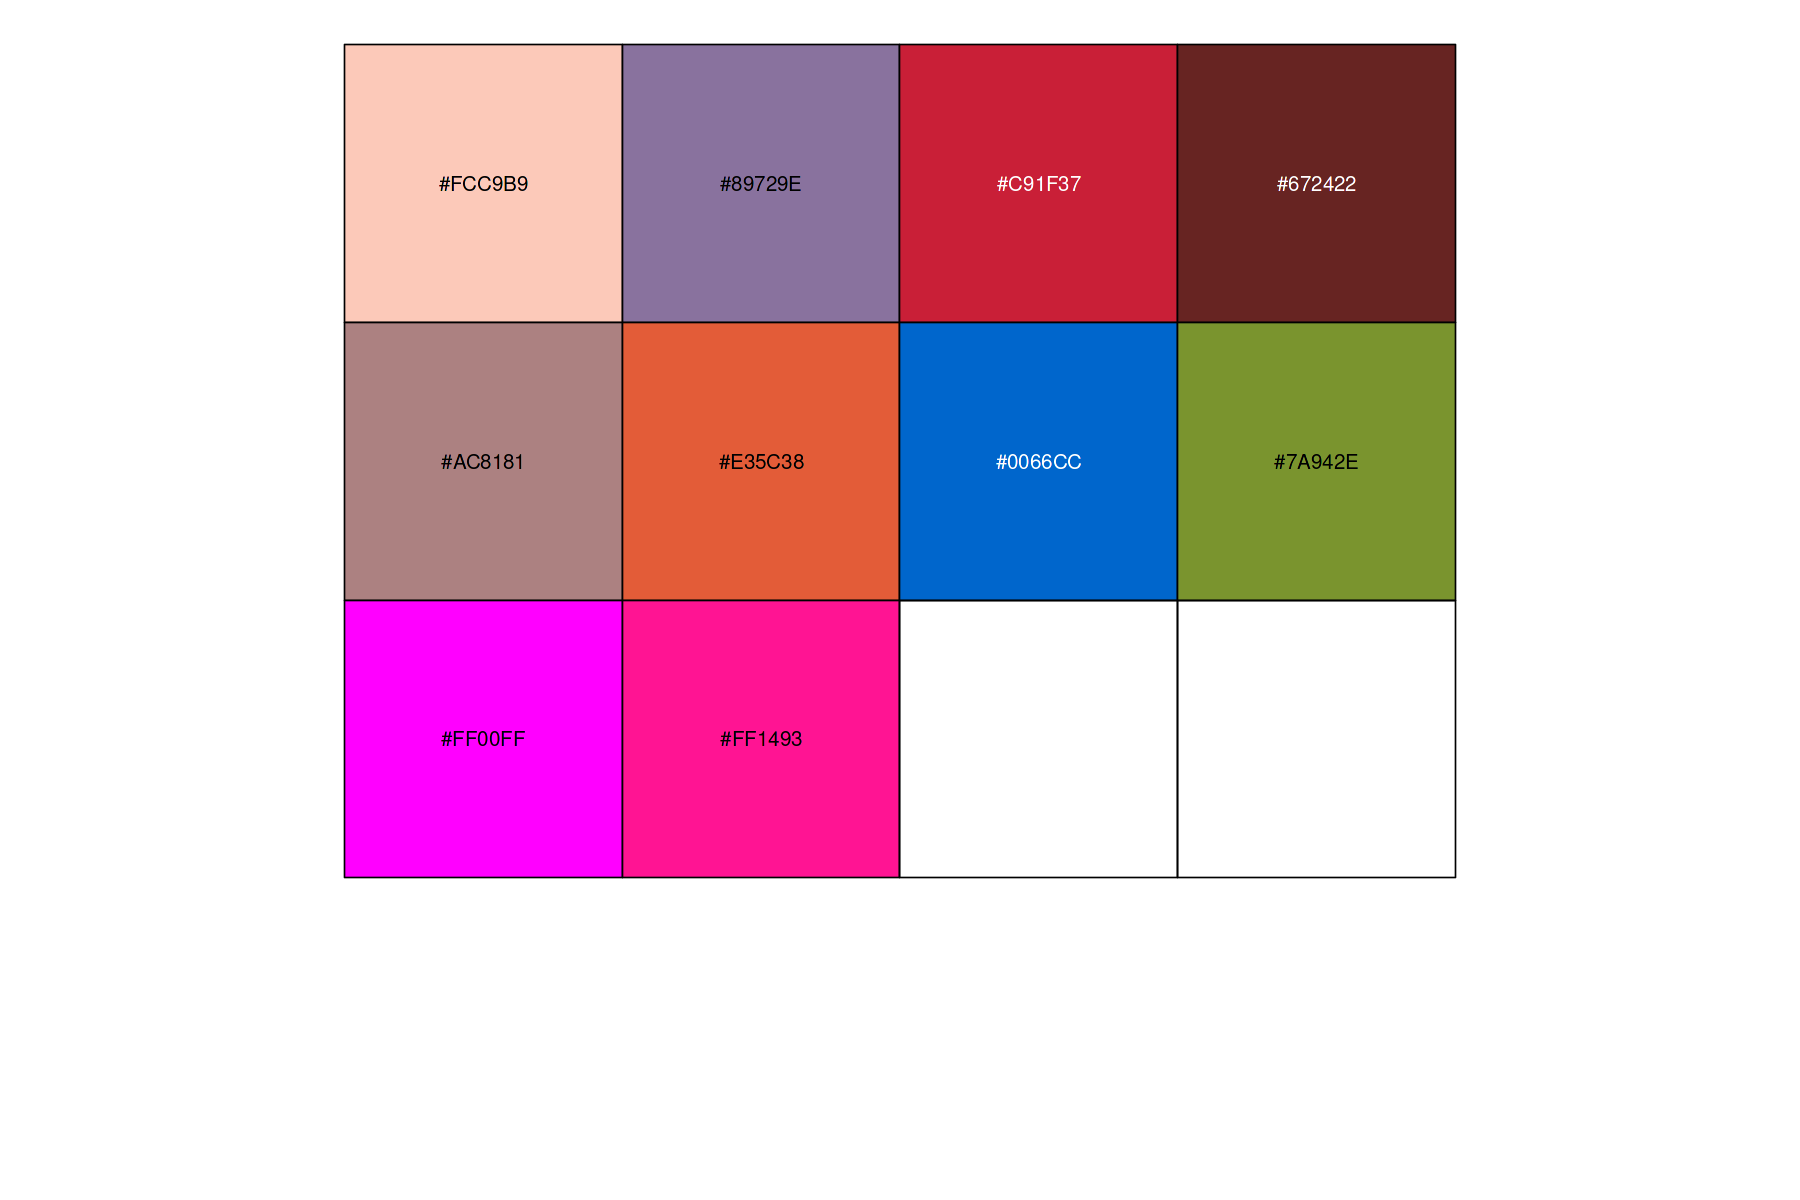

In [140]:
kColor1 <- "#F08F90" # 一斤染
kColor2 <- "#7A942E" # 鶸萌黄
kColor3 <- "#875F9A" # 藤紫
kColor4 <- "#AC8181"
kColor5 <- '#008080'
kColor6 <- '#800000'
kColor7 <- '#00FFFF'
kColor8 <- '#00FF00'
kColor9 <- '#808000'
kColor10 <- "#E6B333" # 琥珀
kColor11 <- "#5B5EA6" # 薄花桜
kColor12 <- "#FFDCDC" # フェルナンダ
kColor13 <- "#9B90C2" # 薄色
kColor14 <- "#FFA500" # オレンジ
kColor15 <- "#0066CC" # 青碧
kColor16 <- "#FFD700" # 金
kColor17 <- "#FF1493" # 深紅
kColor18 <- "#A52A2A" # 茶色
kColor19 <- "#00CED1" # ダークターコイズ
kColor20 <- "#FF00FF" # マゼンタ
kColorPalette10 <- c(
   "#FCC9B9", "#89729E", "#C91F37", "#672422", #桜色, 藤色, 唐紅, 小豆色
   "#AC8181", "#E35C38", "#0066CC", "#7A942E", #桜鼠, 蘇比, 唐茶, 鶸萌黄
   "#FF00FF", "#FF1493") #蘇芳, 中紅
 show_col(kColorPalette10)


In [28]:
options(scipen=999)
kLegPadX <- 0.02
kLegPadY <- 1 - 0.04

# **Imports / Exports**

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


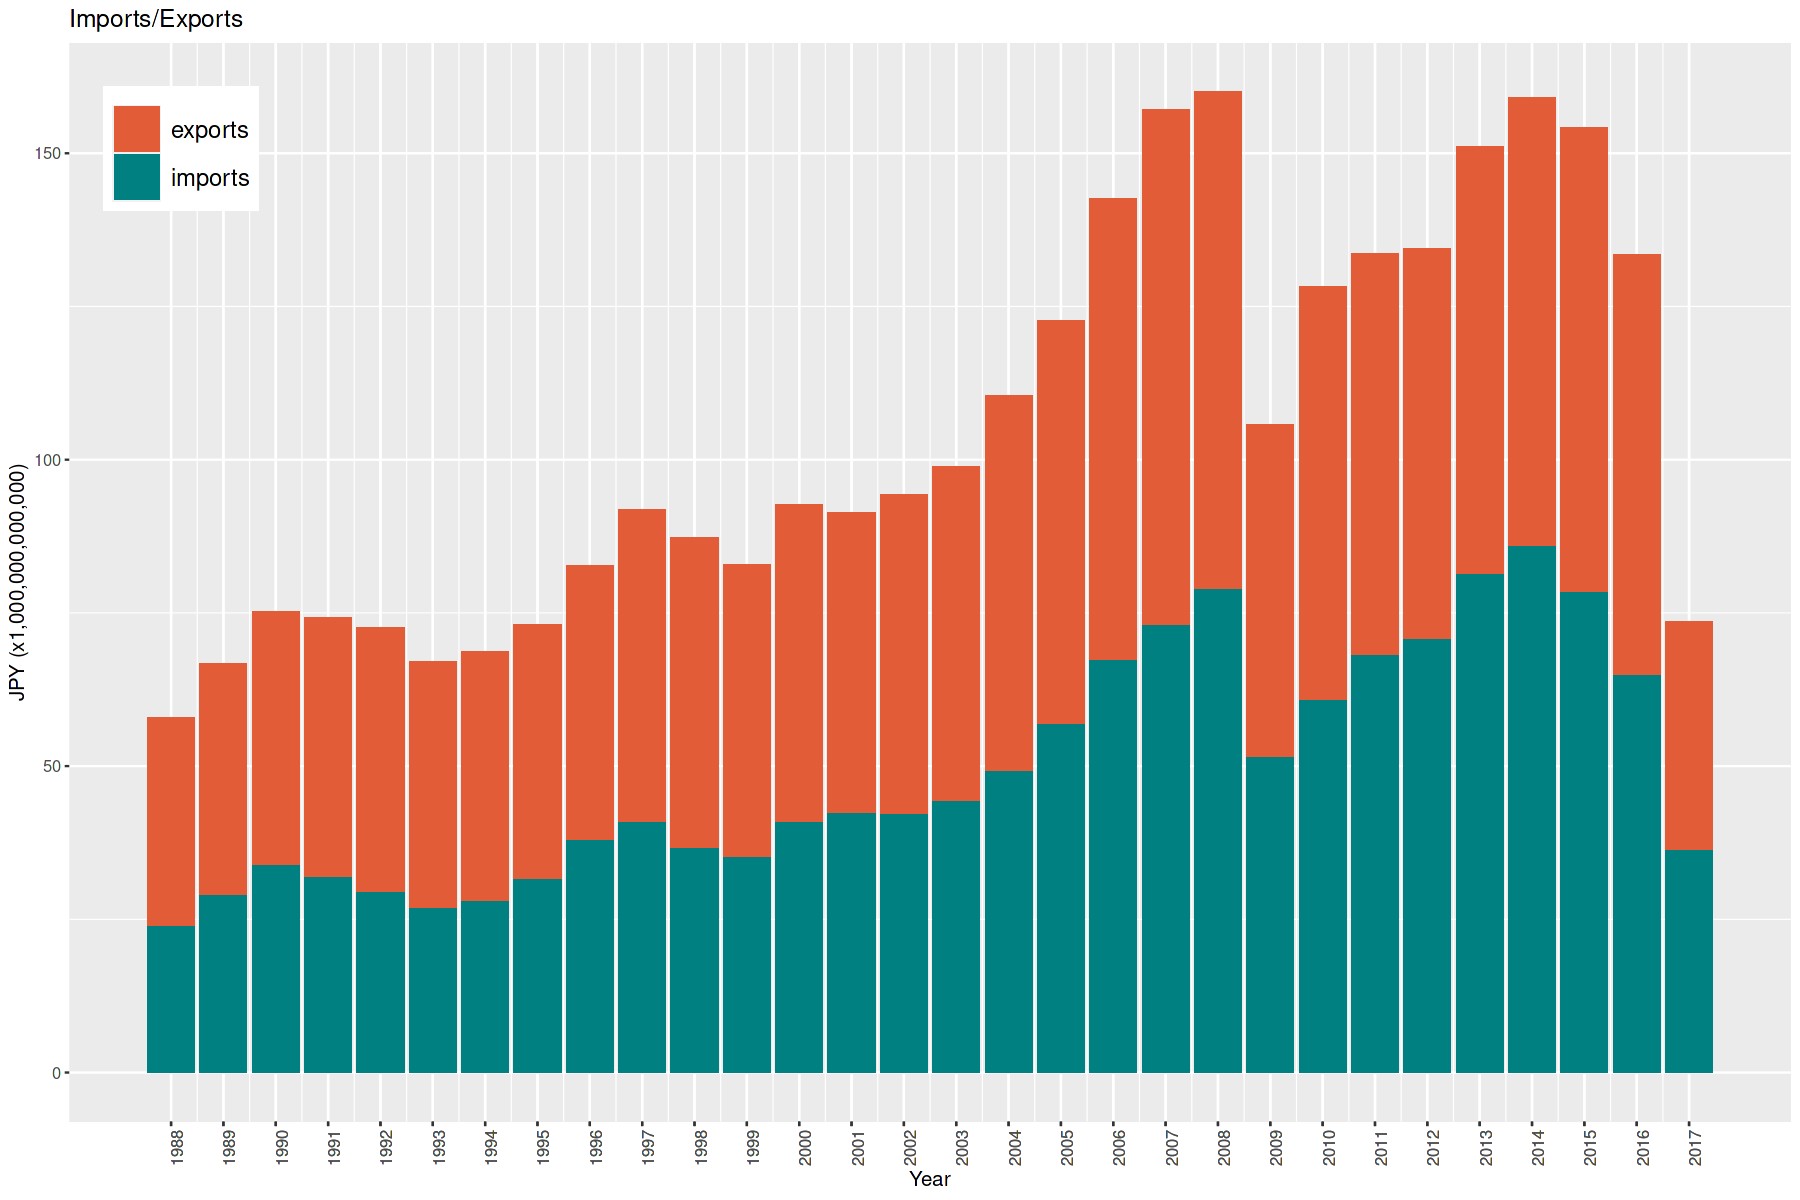

In [29]:
data <- melt(
  setNames(
    data.table(X[["Value"]], X[["Year"]], X[["exp_imp"]]), 
    c("Value", "Year", "exp_imp")),
  measure.vars = c("Value"), value.name = "Value")

# aggData <- as.data.table(aggregate(Value ~ exp_imp + Year , data = data, FUN = sum))
# same as using `aggregate`, but faster
aggData <- data[, .(Value = sum(Value)), by = c("exp_imp", "Year")]
aggData <- aggData[order(Year)]
aggData[, exp_imp := as.factor(exp_imp)]
levels(aggData$exp_imp) <- c("exports", "imports")

factor <- 1000000
aggData[, Value := Value / factor]

# Set the size of the figure
figure_width <- 15  # Adjust the width as desired
figure_height <- 10  # Adjust the height as desired

# Modify the graphics device settings
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

# Create the plot
plot <- ggplot(data = aggData, aes_string(x = "Year", y = "Value", fill = "exp_imp")) +
  geom_bar(stat = "identity") +
  labs(title = "Imports/Exports", y = paste0(
         "JPY (x", format(kYenFactor * factor, nsmall = 0, big.mark = ",", digits = 0), ")")) +
  scale_x_continuous(breaks = aggData$Year) +
  guides(fill = guide_legend(title = NULL)) +
  scale_fill_manual(values = c("exports" = "#E35C38", "imports" = kColor5)) +
  theme(text = element_text(size = 12),
        axis.text.x = element_text(angle = 90, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY),
        legend.key.size = unit(2, "lines"),  # Adjust the legend key size as desired
        legend.text = element_text(size = 14))  # Adjust the legend text size as desired

# Display the plot
print(plot)

 # **Balance of Trade**

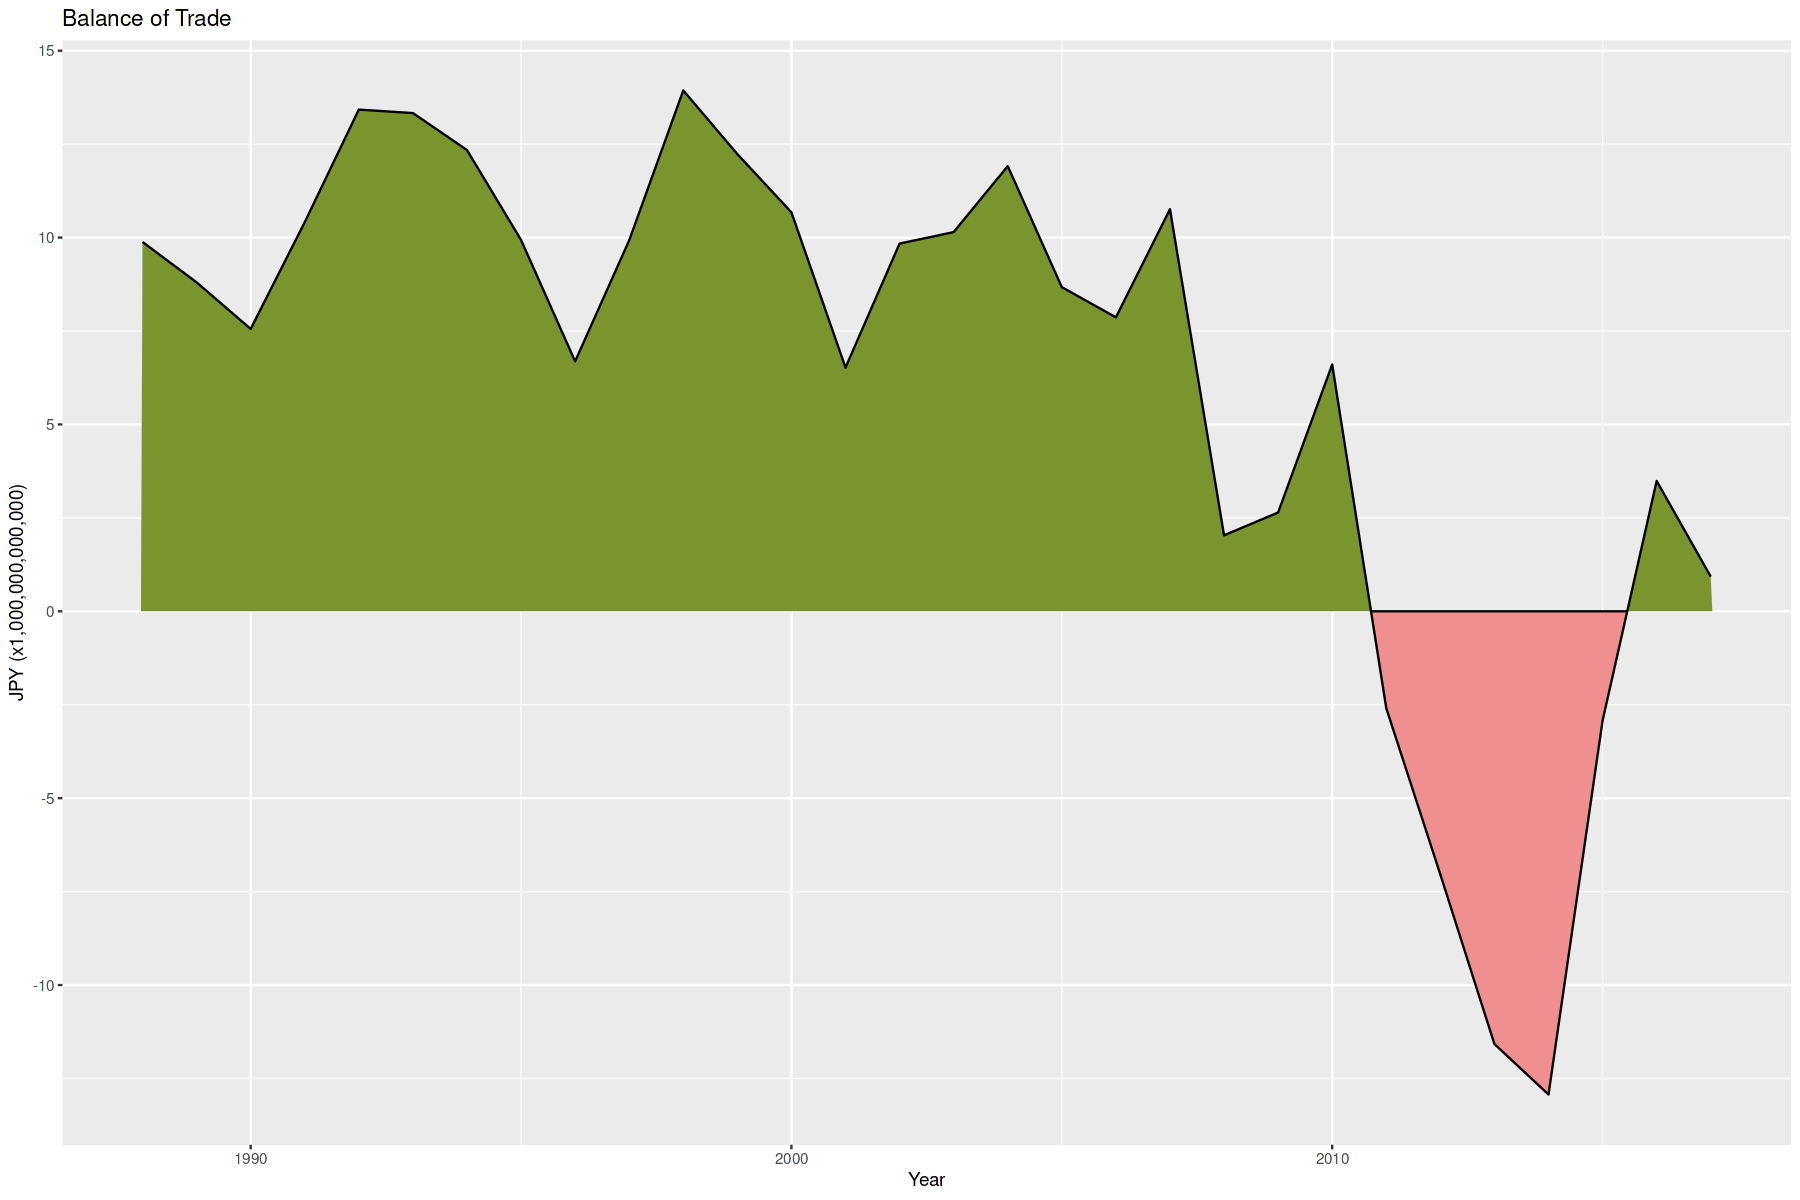

In [30]:
data <- melt(
  setNames(
    data.table(X[["Value"]], X[["Year"]], X[["exp_imp"]]), 
    c("Value", "Year", "exp_imp")),
  measure.vars = c("Value"), value.name = "Value")

# aggData <- as.data.table(aggregate(Value ~ exp_imp + Year , data = data, FUN = sum))
# same as using `aggregate`, but faster
aggData <- data[, .(Value = sum(Value)), by = c("exp_imp", "Year")]
aggData <- aggData[order(Year)]
aggData[, exp_imp := as.factor(exp_imp)]
levels(aggData$exp_imp) <- c("exports", "imports")

aggDataExport <- aggData[exp_imp == "exports", ]
aggDataImport <- aggData[exp_imp == "imports", ]

aggData <- aggData[exp_imp == "exports", ]
aggData[, balance_of_trade := aggDataExport$Value - aggDataImport$Value]

factor <- 1000000
aggData[, balance_of_trade := balance_of_trade / factor]

# https://stackoverflow.com/a/18009173
rx <- do.call("rbind",
   sapply(1:(nrow(aggData)-1), function(i){
   f <- lm(Year~balance_of_trade, aggData[i:(i+1),])
   if (f$qr$rank < 2) return(NULL)
   r <- predict(f, newdata = data.frame(balance_of_trade = 0))
   if(aggData[i,]$Year < r & r < aggData[i+1,]$Year)
      return(data.frame(Year = r, balance_of_trade = 0))
    else return(NULL)
 }))
 aggData <- rbind(aggData, rx, fill=TRUE)

figure_width <- 15  # Adjust the width as desired
figure_height <- 10  # Adjust the height as desired

# Modify the graphics device settings
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

# Create the plot
plot <- ggplot(aggData, aes(x = Year, y = balance_of_trade, fill = exp_imp)) + 
  geom_area(data = subset(aggData, balance_of_trade <= 0), fill = kColor1) + 
  geom_area(data = subset(aggData, balance_of_trade >= 0), fill = kColor2) +
  labs(title = "Balance of Trade", 
       y = paste0("JPY (x", format(kYenFactor * factor, nsmall = 0, big.mark = ",", digits = 0), ")")) +
  geom_line() +
  scale_fill_manual(values = c("exports" = kColor1, "imports" = kColor2)) +
  theme(legend.key.size = unit(2, "lines"),  # Adjust the legend key size as desired
        legend.text = element_text(size = 12))  # Adjust the legend text size as desired

# Display the plot
print(plot)

In [31]:
balanceOfTrade <- aggData[, .(Year, balance_of_trade)]
balanceOfTrade[, balance_of_trade := balance_of_trade * factor]
balanceOfTrade <- balanceOfTrade[-which(balanceOfTrade$balance_of_trade == 0), ]
rm(rx, aggData, aggDataExport, aggDataImport, factor)
gc()
yrFrom <- 2010
yrTo <- 2016
data <- melt(
  setNames(
    data.table(X[["Value"]], X[["Year"]], X[["hs2_name"]], X[["exp_imp"]]), 
    c("Value", "Year", "hs2_name", "exp_imp")),
  measure.vars = c("Value"), value.name = "Value")


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1605169,85.8,4793543,256.1,6863850,366.6
Vcells,160362167,1223.5,412984499,3150.9,412650119,3148.3


In [32]:
getVariation <- function(data, yrFrom, yrTo, decreasing) {
  aggData <- as.data.table(aggregate(Value ~ Year + hs2_name, data = data, FUN = sum))
  
  hss <- c()
  delta <- list()
  for (hs in unique(aggData$hs2_name)) {
    for (y in seq(yrFrom, yrTo - 1, 1)) {
      yr1 <- y
      yr2 <- y + 1
      d1 <- aggData[hs2_name == hs & Year == yr1, ]$Value
      d2 <- aggData[hs2_name == hs & Year == yr2, ]$Value
      key <- paste0("delta_", yr1, "-", yr2)
      delta[[key]] <- c(delta[[key]], d2 - d1)
    }
    hss <- c(hss, hs)
  }
  
  variation <- data.frame(hs = hss)
  for (n in names(delta)) {
    variation[[n]] <- delta[[n]]
  }
  
  order_cols <- names(variation)[-1]
  variation <- variation[do.call(order, c(variation[order_cols], decreasing = decreasing)), ]
  
  return(variation)
}

# imports
variationImports <- getVariation(data[data$exp_imp == 2, ], yrFrom, yrTo, decreasing = TRUE)

# exports
variationExports <- getVariation(data[data$exp_imp == 1, ], yrFrom, yrTo, decreasing = FALSE)


# Import

In [33]:
colNames <- c("Harmonized Commodity Description", paste0("\U0394(", seq(yrFrom %% 2000, yrTo %% 2000 - 1), ", ", seq(yrFrom %% 2000 + 1, yrTo %% 2000), ")"))
names(variationImports) <- colNames

# Format the numeric columns
for (i in 2:ncol(variationImports)) {
  variationImports[[i]] <- formatC(variationImports[[i]], format = "d", big.mark = ",", digits = 0)
}

# Display the table
knitr::kable(head(variationImports, 8), format = "simple", row.names = FALSE, align = c("l", rep("r", yrTo - yrFrom)))



Harmonized Commodity Description                                                                                                         Δ(10, 11)   Δ(11, 12)   Δ(12, 13)   Δ(13, 14)    Δ(14, 15)    Δ(15, 16)
--------------------------------------------------------------------------------------------------------------------------------------  ----------  ----------  ----------  ----------  -----------  -----------
Mineral fuels  mineral oils and products of their distillation; bituminous substances; mineral waxes.                                    4,435,020   2,266,741   3,340,289     247,699   -9,493,215   -6,221,963
Ores  slag and ash.                                                                                                                        288,037    -265,756     244,592     111,118     -716,337     -625,783
Inorganic chemicals; organic or inorganic compounds of precious metals  of rare-earth metals  of radioactive elements or of isotopes.      214,231    -287,884    

In [34]:
colNames <- c("Harmonized Commodity Description", paste0("\U0394(", seq(yrFrom %% 2000, yrTo %% 2000 - 1), ", ", seq(yrFrom %% 2000 + 1, yrTo %% 2000), ")"))
names(variationExports) <- colNames

# Format the numeric columns
for (i in 2:ncol(variationExports)) {
  variationExports[[i]] <- formatC(variationExports[[i]], format = "d", big.mark = ",", digits = 0)
}

# Display the table
knitr::kable(head(variationExports, 8), format = "simple", row.names = FALSE, align = c("l", rep("r", yrTo - yrFrom)))



Harmonized Commodity Description                                                                                                                                                             Δ(10, 11)   Δ(11, 12)   Δ(12, 13)   Δ(13, 14)   Δ(14, 15)    Δ(15, 16)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------  ----------  ----------  ----------  ----------  -----------
Electrical machinery and equipment and parts thereof; sound recorders and reproducers  television image and sound recorders and reproducers  and parts and accessories of such articles.    -1,189,979    -265,911     516,995     453,610     549,774     -994,521
Vehicles other than railway or tramway rolling-stock  and parts and accessories thereof.                                                                                                    -1,060,137   1,214,860   1,490

# Energy Crisis

In [35]:
beginYr <- 2006 
endYr <- 2016

In [36]:
hs4Coal <- c(2701)
hs4Oil <- c(2709, 2710)
hs4Gas <- c(2711)
hs4FossilEnergyRelated <- c(hs4Coal, hs4Oil, hs4Gas)

energyTrade <- X[which(X$hs4 %in% hs4FossilEnergyRelated), ]

# Extract the desired columns and remove duplicates
energyTradeUnique <- unique(energyTrade[, .(hs4, gsub("_", " ", hs4_name))])

# Rename the columns
colNames <- c("HS Code", "Description")
names(energyTradeUnique) <- colNames

# Generate the table as a character string
table_str <- knitr::kable(energyTradeUnique, format = "simple", row.names = FALSE, align = c("l", "l"))

# Display the table
cat(table_str)


HS Code   Description                                                                                                                                                                                                                                                                                              --------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 2701      Coal; briquettes  ovoids and similar solid fuels manufactured from coal                                                                                                                                                                                                                                  2709      Petroleum oils and oils obtained from bituminous minerals  crude     

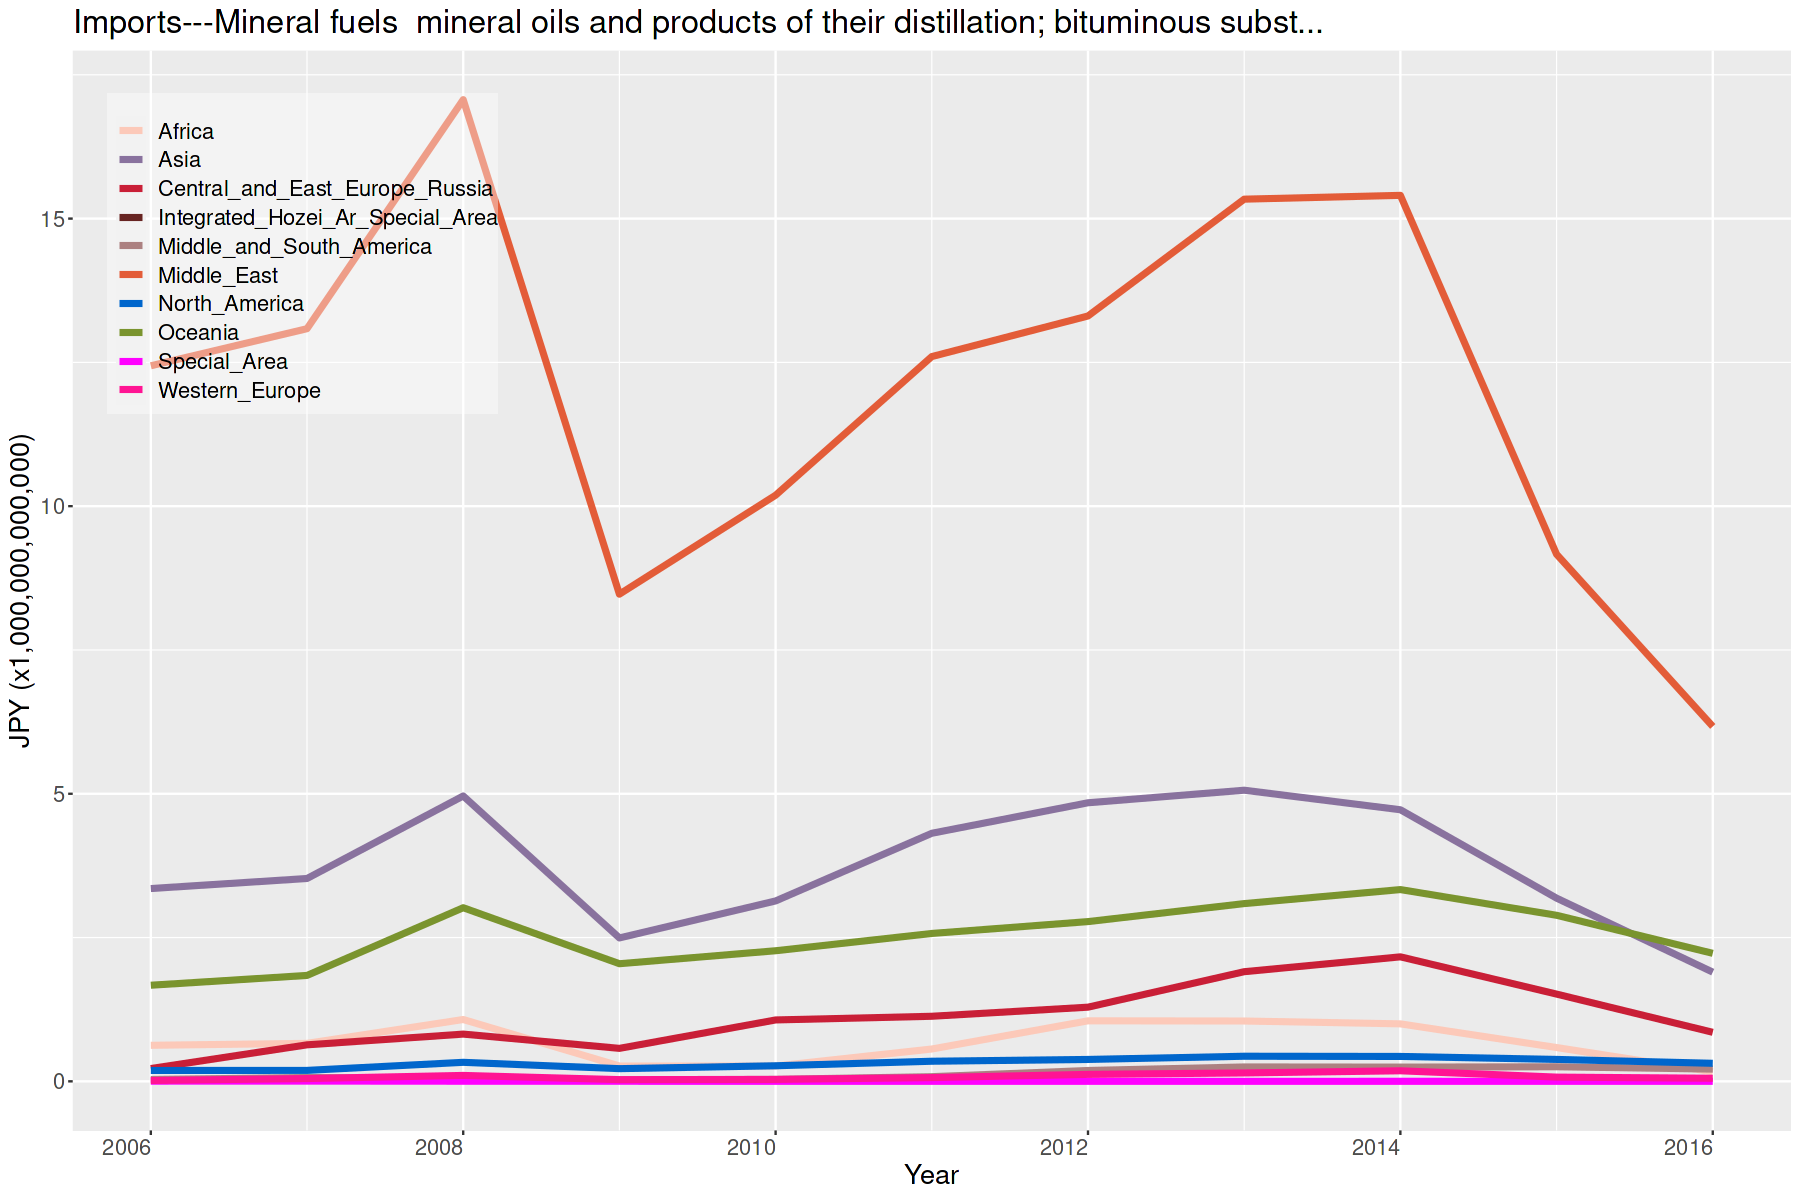

In [142]:
data <- melt(
  setNames(
    data.table(energyTrade[["Value"]], 
               energyTrade[["Year"]], 
               energyTrade[["Area"]], 
               energyTrade[["exp_imp"]]), 
    c("Value", "Year", "Area", "exp_imp")),
  measure.vars = c("Value"), value.name = "Value")

data <- data[Year >= beginYr & Year <= endYr, ]
data <- data[exp_imp == 2, ] # imports
aggData <- as.data.table(aggregate(Value ~ Area + Year, data = data, FUN = sum))

factor <- 1000000
aggData[, Value := Value / factor]

ggplot(data = aggData, aes(x = Year, y = Value, color = Area)) +
  geom_line(linewidth = 1.5) +
  labs(title = paste0("Imports---", substr(energyTrade$hs2_name[1], 1, 80), "..."), 
       y = paste0(
         "JPY (x", format(kYenFactor * factor, 
                          nsmall = 0, 
                          big.mark = ",", 
                          digits = 0), ")")) +
  scale_color_manual(values = kColorPalette10) +
  theme(text = element_text(size = 16), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY), 
        legend.background = element_rect(fill = alpha('white', 0.4)))

In [ ]:
rm(data, aggData, factor)
gc()

# Estimation of the Number of Barrels (“Equivalent”)

In [44]:
oilPriceDataYearly <- data.table(
   Year = c("2016", "2015", "2014", "2013", "2012", "2011", "2010", "2009", "2008", "2007", "2006", "2005", "2004", "2003", "2002", "2001", "2000", "1999", "1998", "1997", "1996", "1995", "1994", "1993", "1992", "1991", "1990", "1989", "1988", "1987", "1986"),
   Value = c("43.29", "48.66", "93.17", "97.98", "94.05", "94.88", "79.48", "61.95", "99.67", "72.34", "66.05", "56.64", "41.51", "31.08", "26.18", "25.98", "30.38", "19.34", "14.42", "20.61", "22.12", "18.43", "17.2",  "18.43", "20.58", "21.54", "24.53", "19.64", "15.97", "19.2", "15.05"))
oilPriceDataYearly[, Year := as.integer(Year)]
oilPriceDataYearly[, Value := as.numeric(Value)]

usdJpyRateYearly <- data.table(
  Year = c("1971", "1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"),
  Value = c("347.785690376569", "303.124980079681", "271.30548", "291.8446", "296.78488", "296.454404761905", "268.61936", "210.3854", "219.0168", "226.630916334661", "220.62812749004", "249.060119521912", "237.553505976096", "237.46216", "238.46732", "168.349601593625", "144.602261904762", "128.174183266932", "138.073824701195", "144.998685258964", "134.590916334661", "126.780118577075", "111.075476190476", "102.178964143426", "93.9649402390438", "108.78", "121.05812749004", "130.989166666667", "113.734246031746", "107.804047619048", "121.56804", "125.220438247012", "115.938685258964", "108.150830039526", "110.106932270916", "116.312071713147", "117.762322834646", "103.390634920635", "93.6826587301587", "87.78168", "79.6966533864542", "79.8180079681275", "97.5971314741036", "105.7398", "121.049083665339", "108.656932270916", "112.256644295302"))
usdJpyRateYearly[, Year := as.integer(Year)]
usdJpyRateYearly[, Value := as.numeric(Value)]

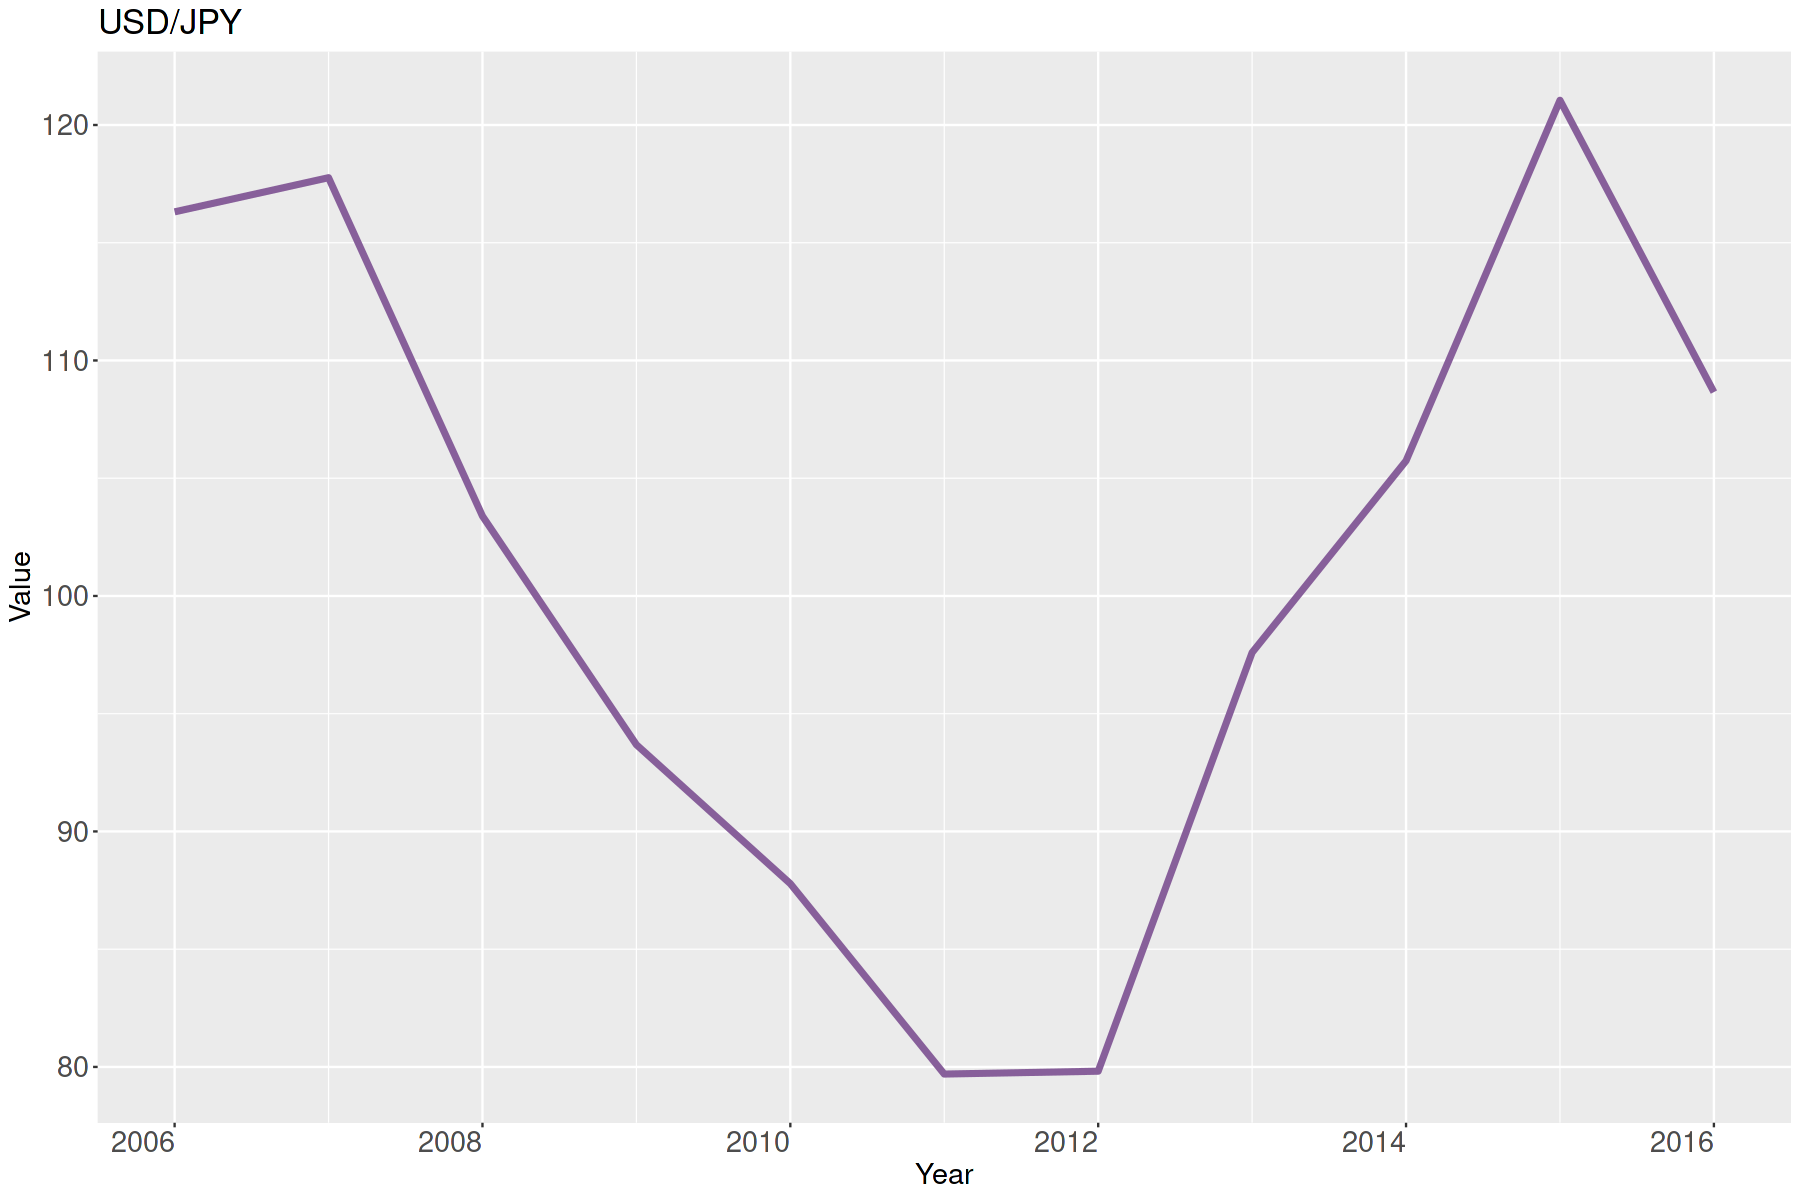

In [47]:
ggplot(data = usdJpyRateYearly[Year >= beginYr & Year <= endYr, ],
       aes(x = Year, y = Value)) +
  geom_line(size = 1.5, color = kColor3) + 
  labs(title = "USD/JPY") +
  theme(text = element_text(size = 17),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 17, angle = 0, hjust = 1),
        axis.text.y = element_text(size = 17))

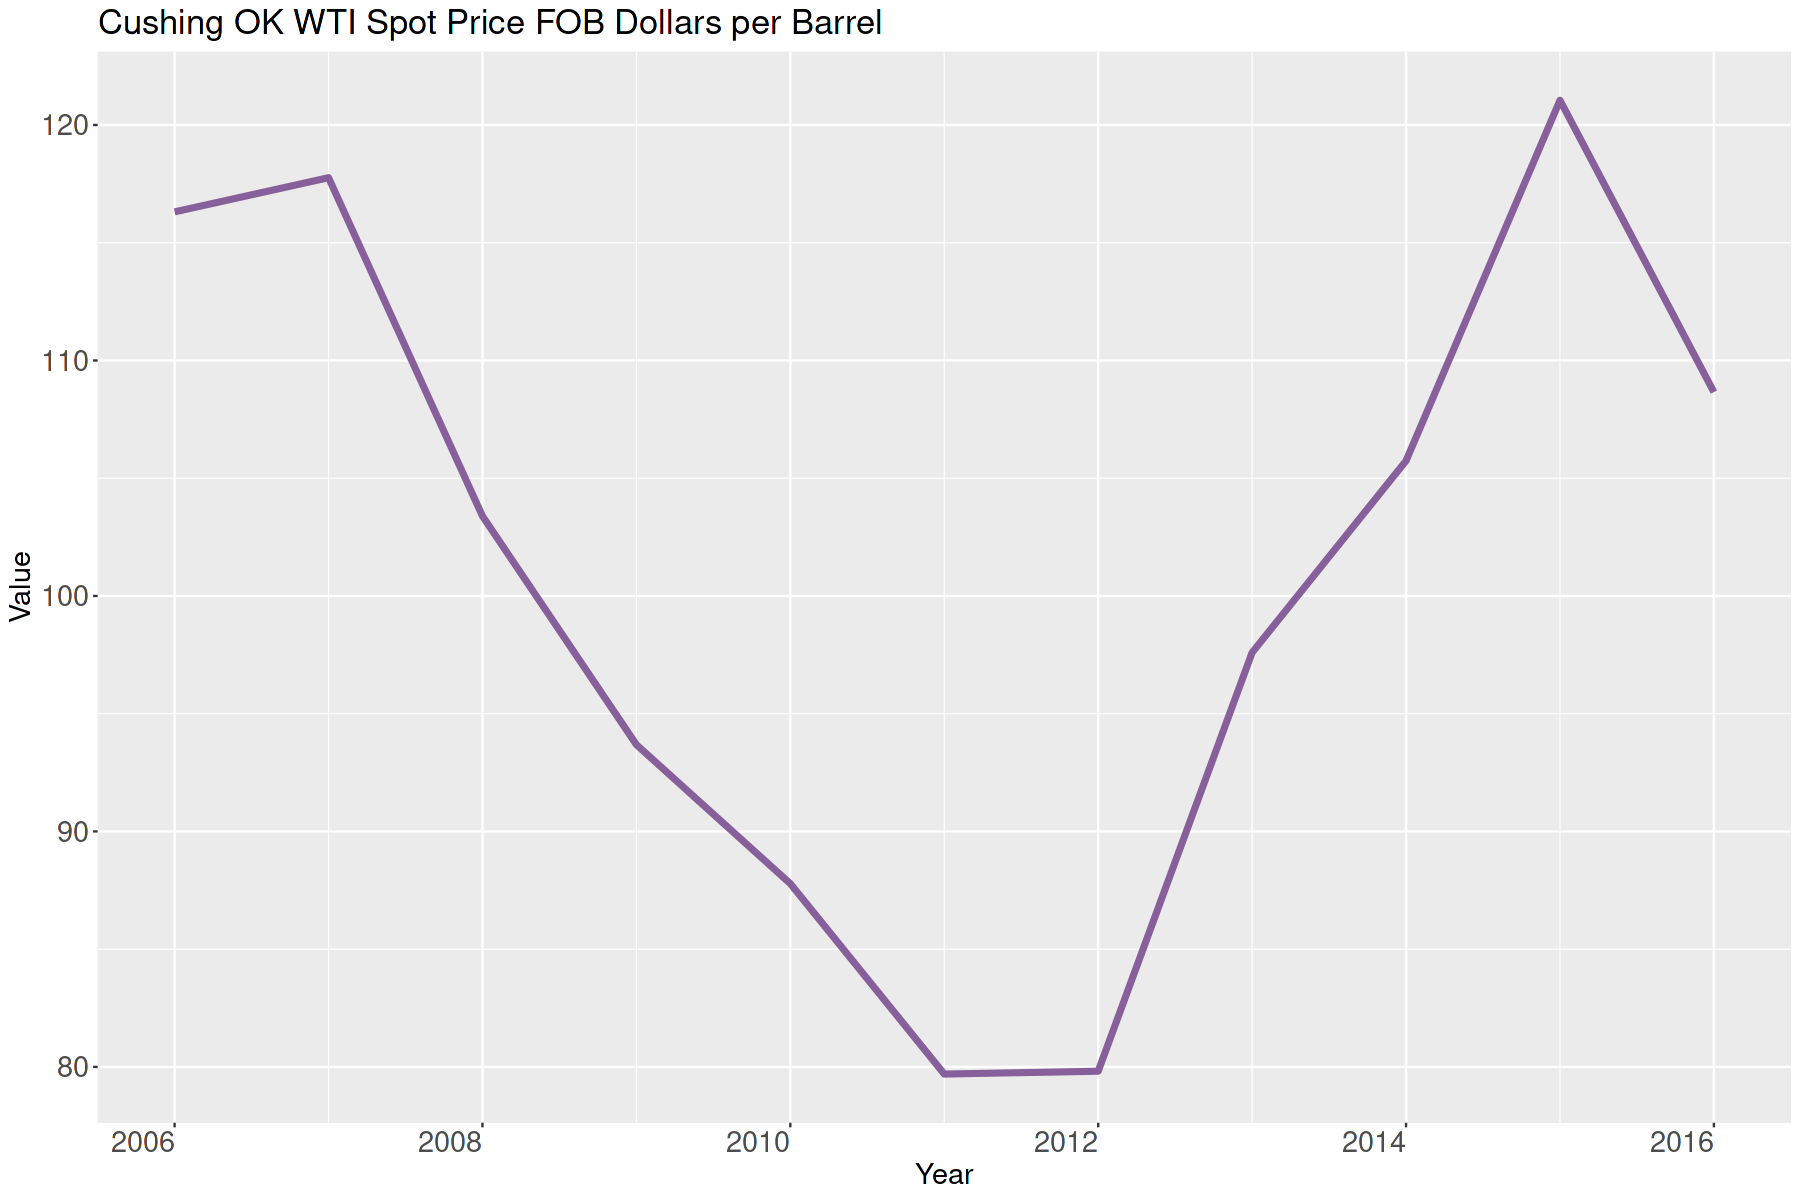

In [49]:
ggplot(data = usdJpyRateYearly[Year >= beginYr & Year <= endYr, ],
       aes(x = Year, y = Value)) +
  geom_line(size = 1.5, color = kColor3) + 
  labs(title = "Cushing OK WTI Spot Price FOB Dollars per Barrel") +
  theme(text = element_text(size = 17),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 17, angle = 0, hjust = 1),
        axis.text.y = element_text(size = 17))

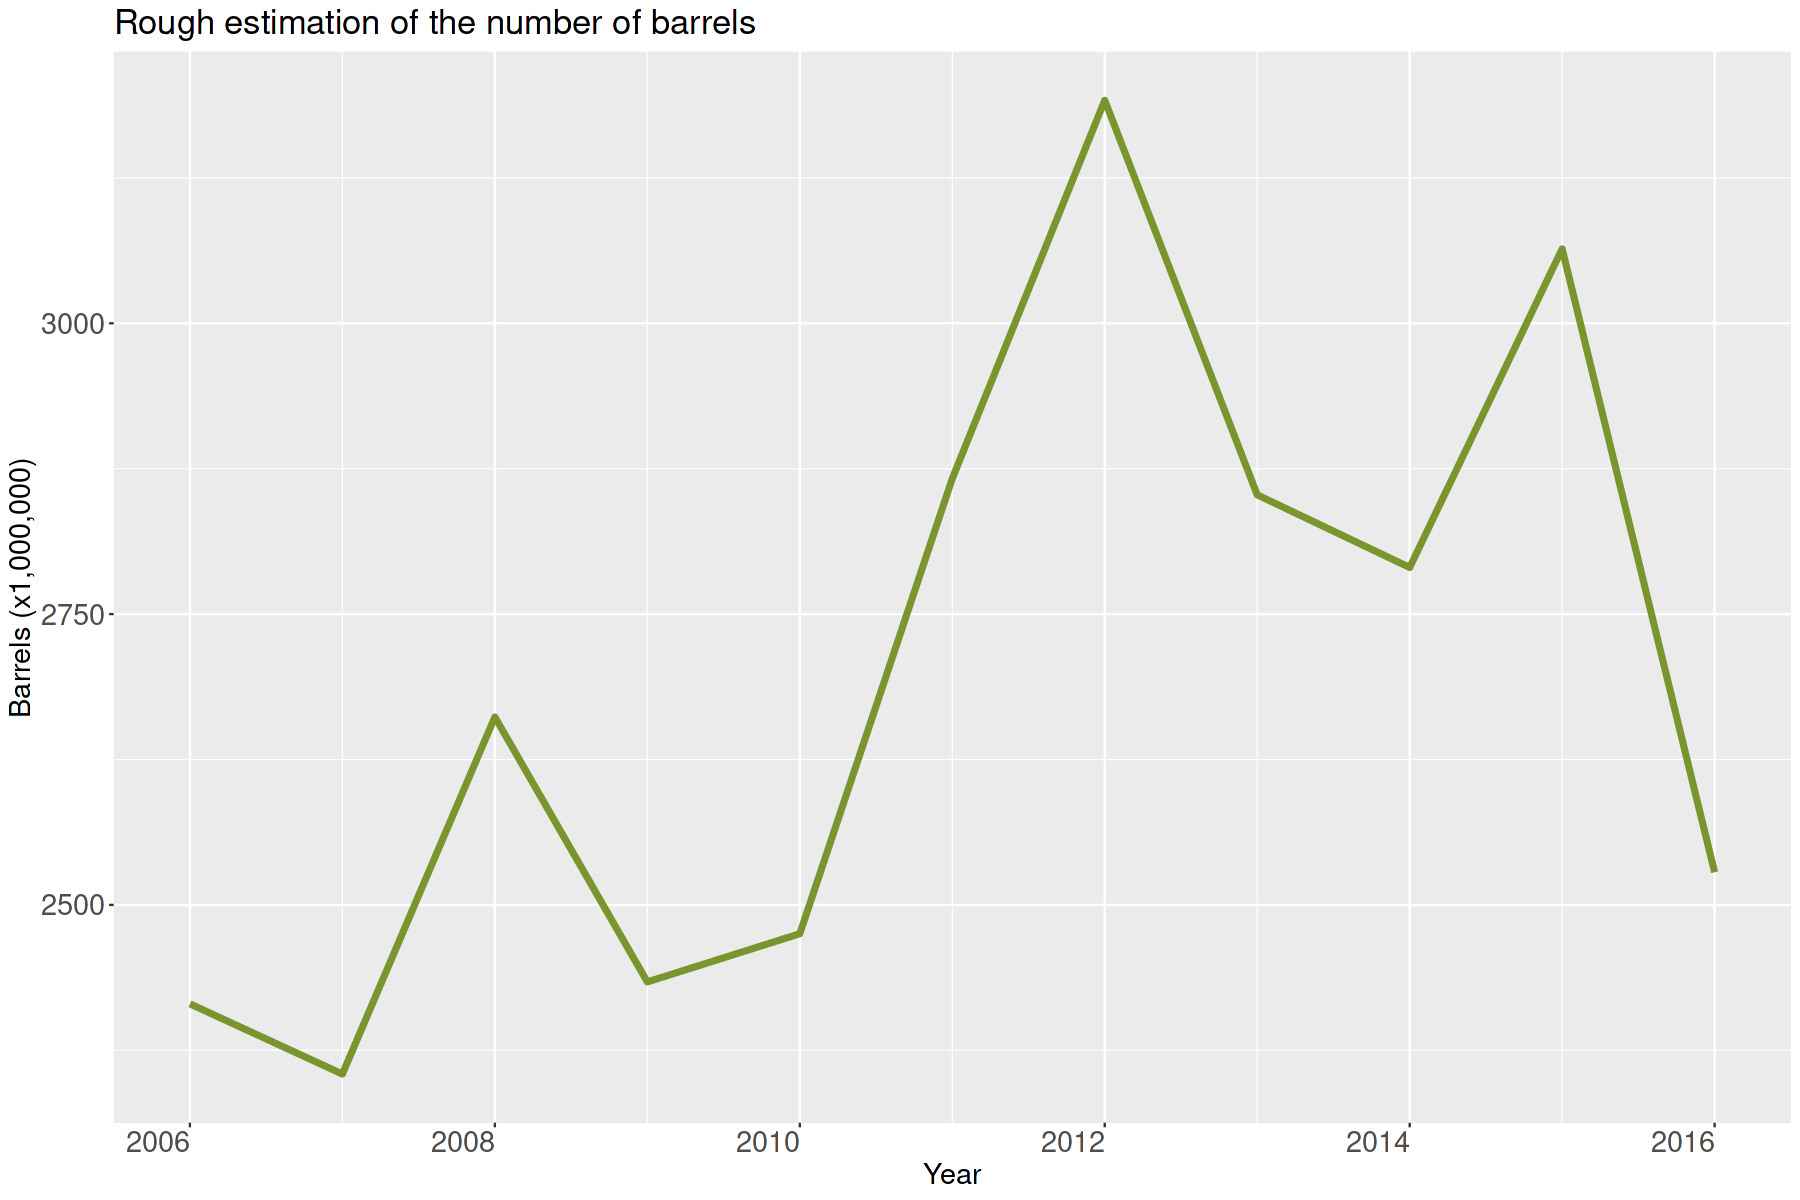

In [57]:
data <- melt(
    setNames(
      data.table(
        energyTrade[["Value"]], 
        energyTrade[["Year"]], 
        energyTrade[["Area"]], 
        energyTrade[["exp_imp"]]), 
      c("Value", "Year", "Area", "exp_imp")),
    measure.vars = c("Value"), value.name = "Value")

data <- data[Year >= beginYr & Year <= endYr & exp_imp == 2, ]
aggData <- as.data.table(aggregate(Value ~ Year, data = data, FUN = sum))

names(usdJpyRateYearly)[names(usdJpyRateYearly) == "Value"] <- "usd_jpy"
aggData <- merge (aggData, usdJpyRateYearly, by = "Year")

names(oilPriceDataYearly)[names(oilPriceDataYearly) == "Value"] <- "usd_barrels"
aggData <- merge (aggData, oilPriceDataYearly, by = "Year")

aggData[, barrels := Value / usd_jpy /  usd_barrels]

ggplot(data=aggData,
       aes(x = Year, y = barrels)) +
  geom_line(size = 1.5, color = kColor2) + 
  labs(title = paste0("Rough estimation of the number of barrels"),
       y = paste0(
         "Barrels (x", format(kYenFactor, nsmall = 0, big.mark = ",", digits = 0), ")")) +
  theme(text = element_text(size = 17),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 17, angle = 0, hjust = 1),
        axis.text.y = element_text(size = 17), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY))

# Quantity of Imported Energy

In [52]:
energyTrade[, Q1 := ifelse(is.na(Q1), 0, Q1)]
energyTrade[, Q2 := ifelse(is.na(Q2), 0, Q2)]
energyTrade[, Unit1 := ifelse(is.na(Unit1), "", Unit1)]
energyTrade[, Unit2 := ifelse(is.na(Unit2), "", Unit2)]

# we approximate that 1 KL corresponds to 0.858 MT

energyTrade[, Q2 := ifelse(Unit2 == "KG", 
                           0.001 * Q2, 
                           ifelse(Unit2 == "KL", 
                                  0.858 * Q2, 
                                  Q2))]
energyTrade[, Unit2 := "MT"]

energyTrade[, Q1 := ifelse(Unit1 == "KL", 
                           0.858 * Q1, 
                           Q1)]
energyTrade[, Unit1 := "MT"]

[1] 0.1241302

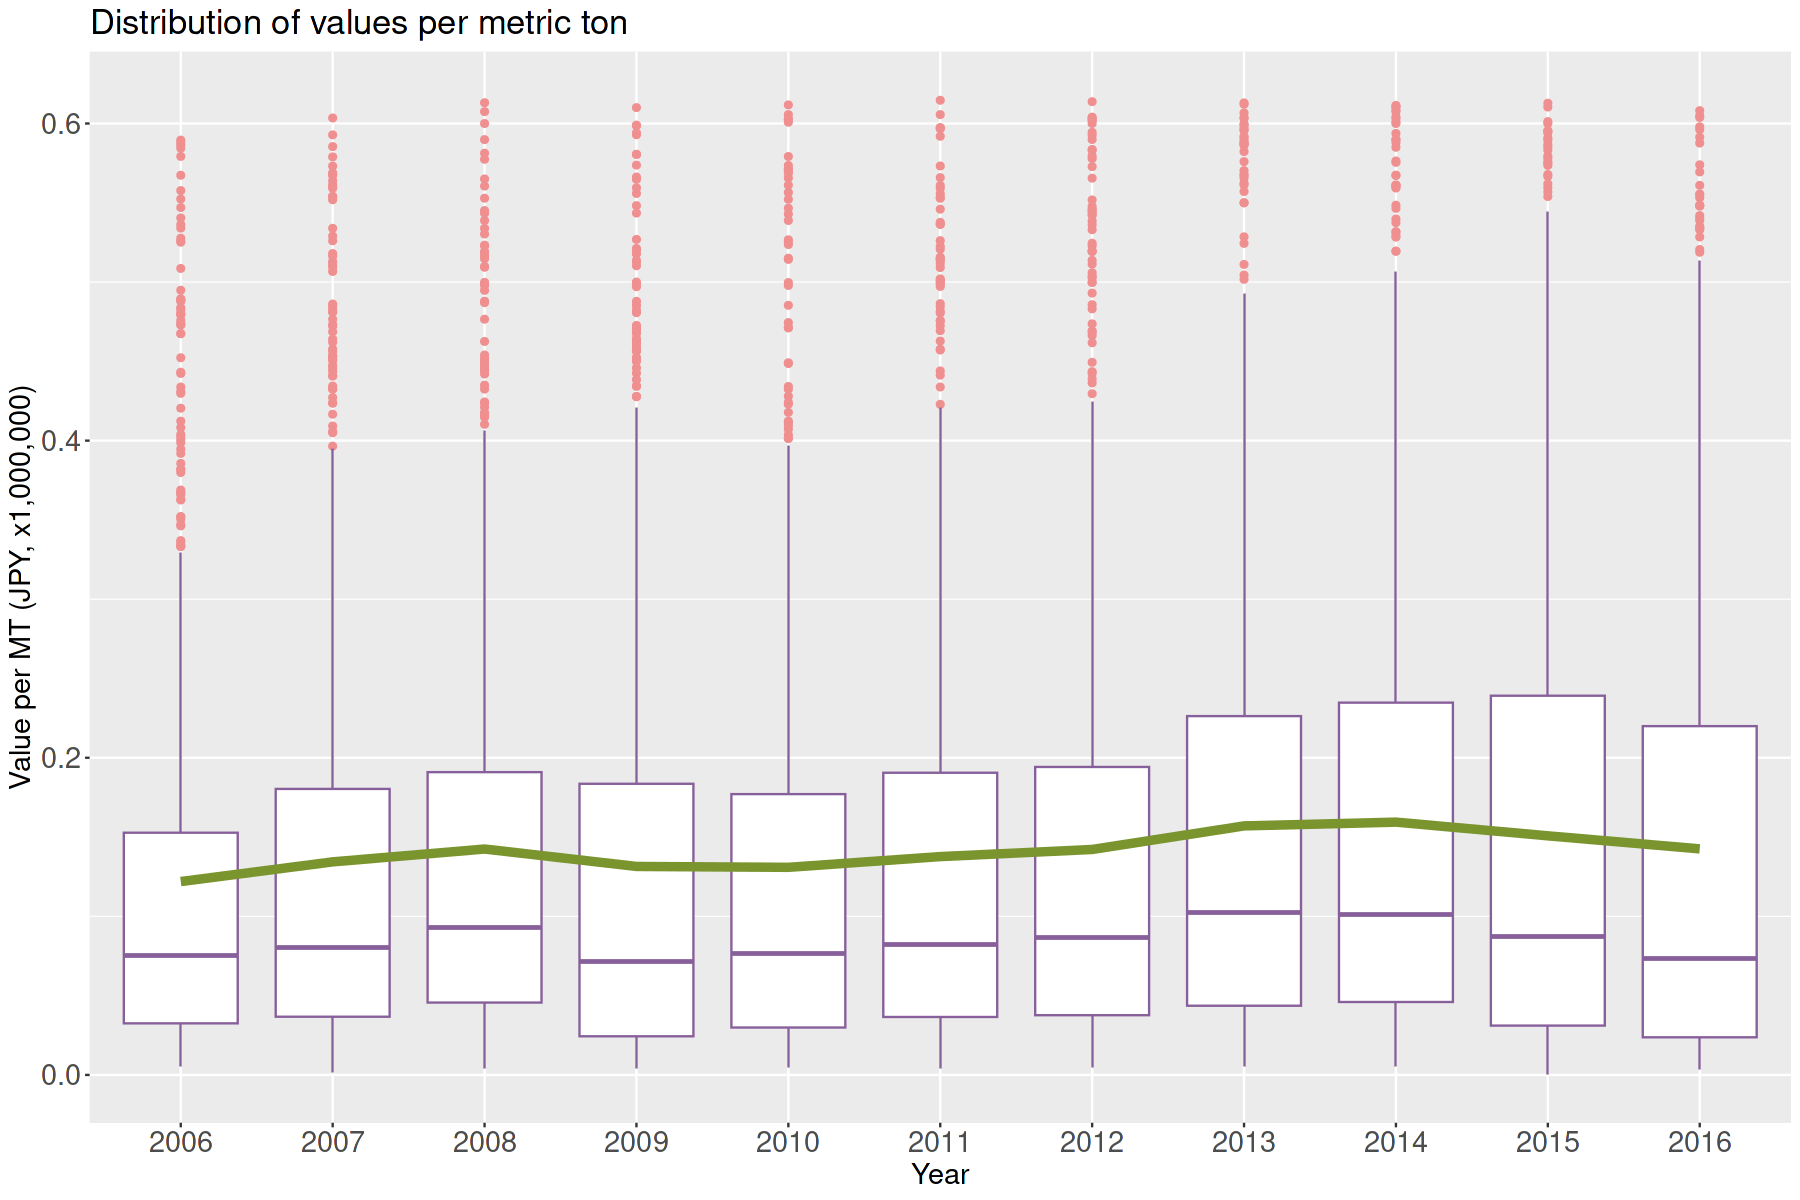

In [59]:
data <- energyTrade[Year >= beginYr & Year <= endYr, ]
data <- data[Q1 + Q2 != 0, ]
data[, value_per_metric_ton := Value / (Q1 + Q2)]

maxThreshold <- 3 * 1.48 * mad(data$value_per_metric_ton, na.rm = TRUE) 
                    + median(data$value_per_metric_ton, na.rm = TRUE)

# to show all the x labels
data$Year <- as.factor(data$Year)

ggplot(data[value_per_metric_ton < maxThreshold], aes(x = Year, y = value_per_metric_ton)) +
  geom_boxplot(aes(group = Year), color = kColor3, outlier.colour = kColor1, outlier.shape = 19) +
  labs(title = "Distribution of values per metric ton",
       y = paste0("Value per MT (JPY, x", format(kYenFactor, nsmall = 0, big.mark = ",", digits = 0), ")"),
       x = "Year") +
  stat_summary(fun=mean, aes(group = 1),
               colour = kColor2, geom = "line", size = 2, show.legend = FALSE) +
  theme(text = element_text(size = 17),
        axis.text.x = element_text(size = 17),
        axis.text.y = element_text(size = 17))



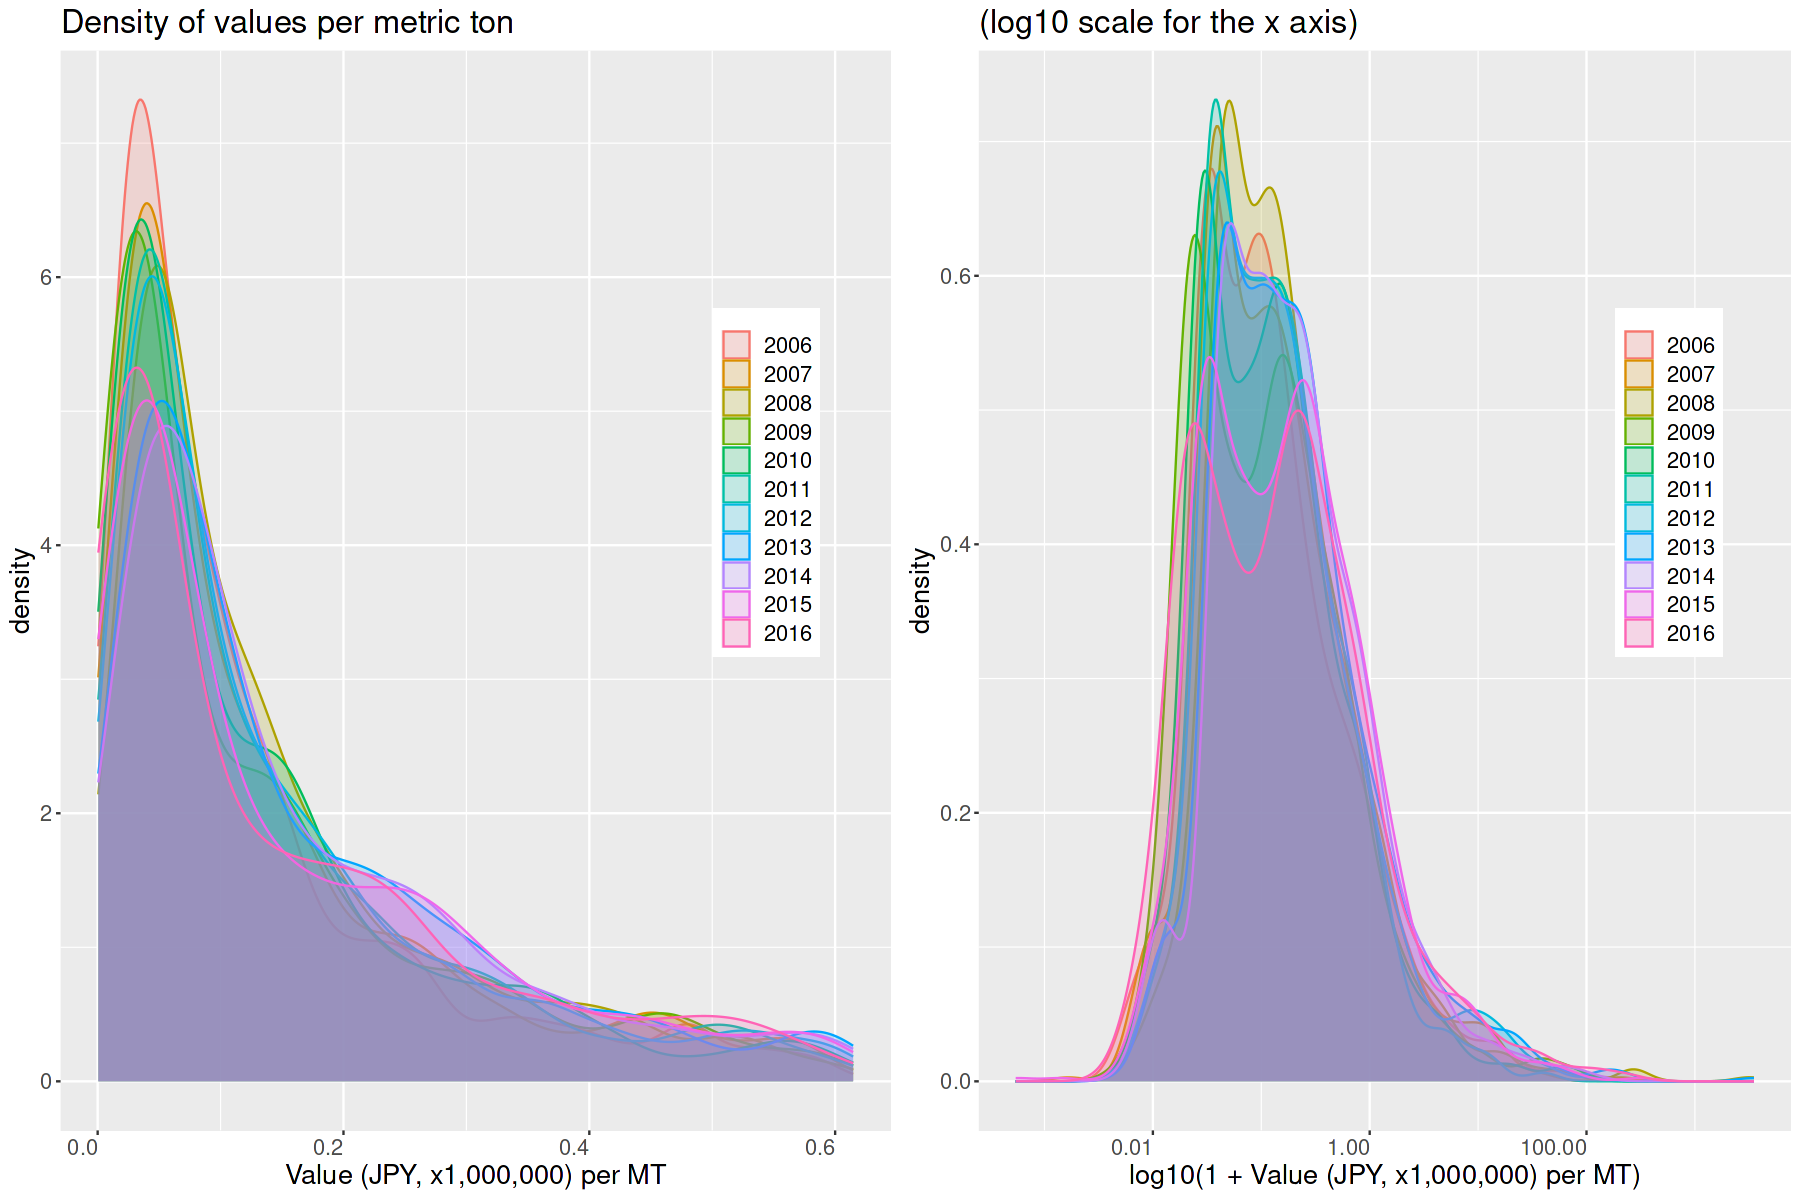

In [66]:
p1 <- ggplot(data[value_per_metric_ton < maxThreshold], aes(x = value_per_metric_ton, group = Year,  fill = Year, color = Year)) +
  geom_density(alpha = 0.2, na.rm = TRUE) +
  labs(title = "Density of values per metric ton", x = paste0("Value (JPY, x", format(kYenFactor, nsmall = 0, big.mark = ",", digits = 0), ")", " per MT"))  +
  theme(text = element_text(size = 16), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.position = c(0.85, 0.60))

p2 <- ggplot(data, aes(x = value_per_metric_ton, group = Year, fill = Year, color = Year)) +
  geom_density(alpha = 0.2, na.rm = TRUE) +
  scale_x_log10() +
  labs(title = "(log10 scale for the x axis)", x = paste0("log10", "(1 + ", "Value (JPY, x", format(kYenFactor, nsmall = 0, big.mark = ",", digits = 0), ")", " per MT)"))  +
  theme(text = element_text(size = 16),
        legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.position = c(0.85, 0.60))

grid.arrange(p1, p2, ncol = 2)

# Energy Imports in Metric Tons

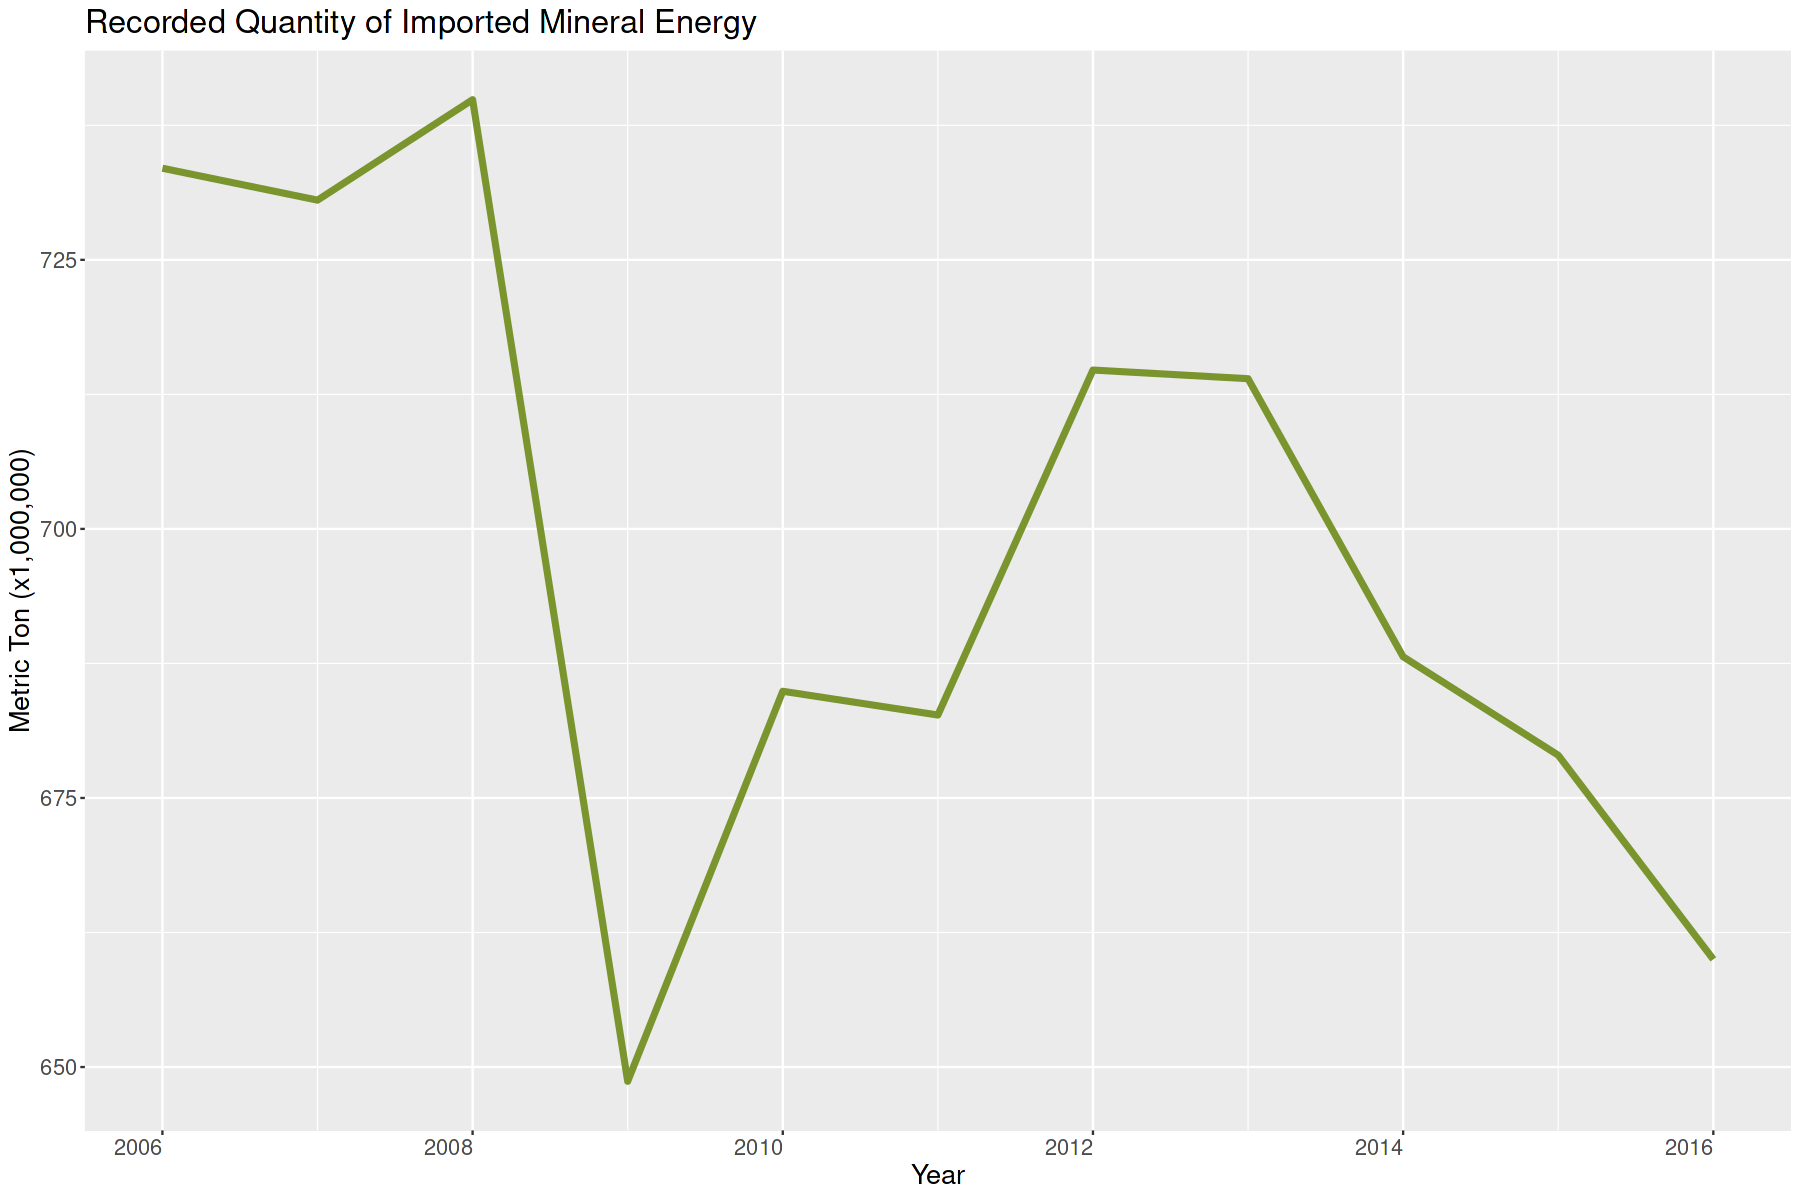

In [69]:
data <- energyTrade[Year >= beginYr & Year <= endYr & exp_imp == 2, ]

aggData <- as.data.table(
  aggregate(
    cbind(Value, Q1, Q2) ~ Year, 
    data = data, 
    FUN = sum))

factor <- 1000000
aggData[, totalQ := (Q1 + Q2) / factor]

ggplot(data = aggData,
       aes(x = Year, y = totalQ)) +
  geom_line(size = 1.5, color = kColor2) + 
  labs(title = paste0("Recorded Quantity of Imported Mineral Energy"), 
       y = paste0(
         "Metric Ton (x", format(factor, nsmall = 0, big.mark = ",", digits = 0), ")")) +
  theme(text = element_text(size = 16), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY))

# Estimation of Energy Imports in Megajoules

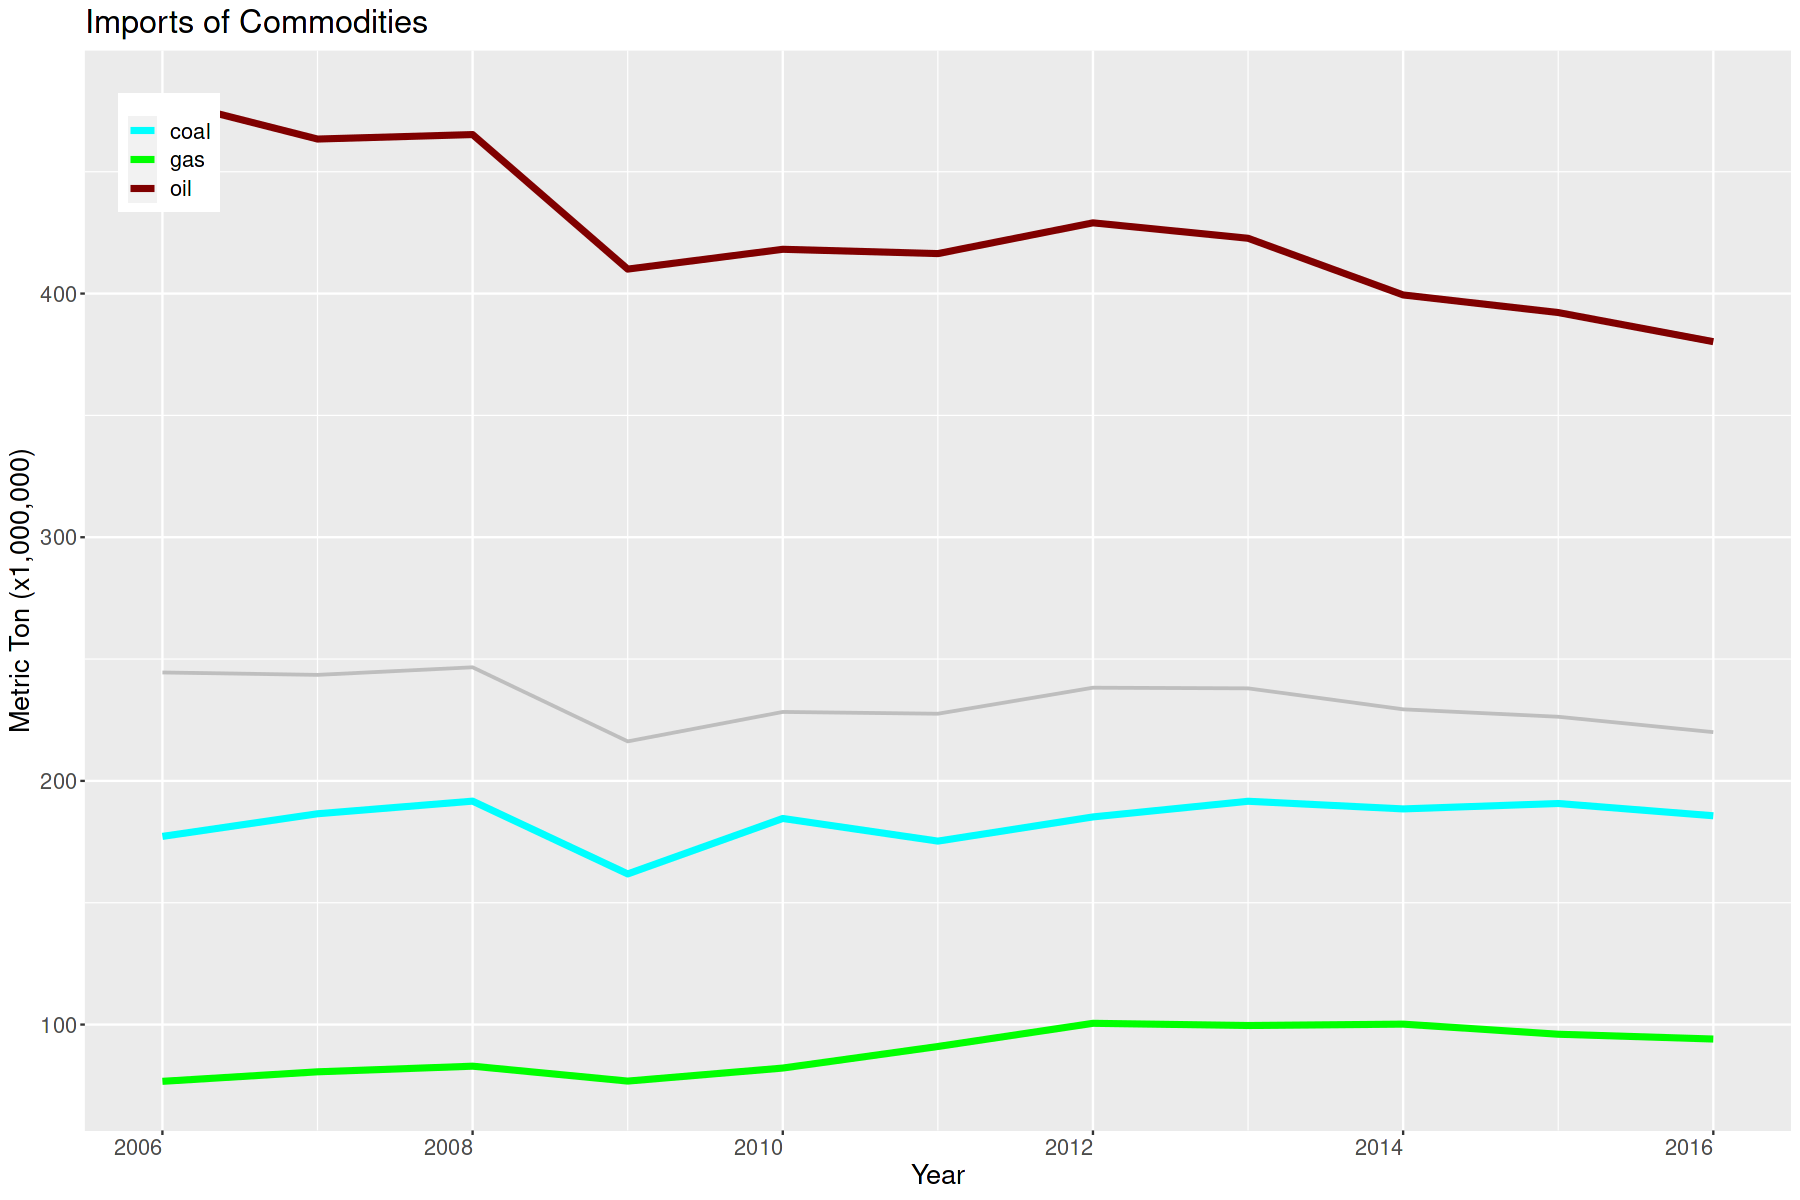

In [146]:
coalData <- energyTrade[
  hs4 %in% hs4Coal & Year >= beginYr & Year <= endYr, ]
oilData <- energyTrade[
  hs4 %in% hs4Oil & Year >= beginYr & Year <= endYr, ]
gasData <- energyTrade[
  hs4 %in% hs4Gas & Year >= beginYr & Year <= endYr, ]

coalData[, commodity := "coal"]
oilData[, commodity := "oil"]
gasData[, commodity := "gas"]
  
aggData <- as.data.table(
  aggregate(
    cbind(Value, Q1, Q2) ~ Year + commodity, 
    data = rbindlist(list(coalData, oilData, gasData), fill = TRUE)[exp_imp == 2], 
    FUN = sum))
factor <- 1000000
aggData[, totalQ := (Q1 + Q2) / factor]
aggData[, commodity := as.factor(commodity)]

ggplot(data = aggData,
       aes(x = Year, y = totalQ, color = commodity)) +
  geom_line(size = 1.5) + 
  labs(title = paste0("Imports of Commodities"), 
       y = paste0(
         "Metric Ton (x", format(factor, nsmall = 0, big.mark = ",", digits = 0), ")")) +
  scale_color_manual(values = c("gas" = kColor8, "oil" = kColor6, "coal" = kColor7)) +
  stat_summary(fun.y = mean, geom = "line", lwd = 0.8, aes(group = 1), color = "grey") +
  theme(text = element_text(size = 16), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY))

# Trades Related to Nuclear Energy

In [72]:
hs6NuclearEnergyRelated <- c(261210, 261220, 284410, 284420, 284430, 284440, 284450, 284510, 284590, 810990, 840110, 840120, 840130, 840140)

nuclearEnergyRelaredTrade <- X[which(X$hs6 %in% hs6NuclearEnergyRelated), ]

# Extract the desired columns and remove duplicates
nuclearEnergyRelaredTradeUnique <- unique(nuclearEnergyRelaredTrade[, .(hs4, gsub("_", " ", hs4_name))])

# Rename the columns
colNames <- c("HS Code", "Description")
names(nuclearEnergyRelaredTradeUnique) <- colNames

# Generate the table as a character string
table_str <- knitr::kable(nuclearEnergyRelaredTradeUnique, format = "simple", row.names = FALSE, align = c("l", "l"))

# Display the table
cat(table_str)

HS Code   Description                                                                                                                                                                                    --------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 2612      Uranium or thorium ores and concentrates                                                                                                                                                       2844      Radioactive chemical elements and radioactive isotopes (including the fissile or fertile chemical elements and isotopes) and their compounds; mixtures and residues containing these products  2845      Isotopes other than those of heading 28.44; compounds  inorganic or organic  of such isotopes  whether or not chemically defined                                                          

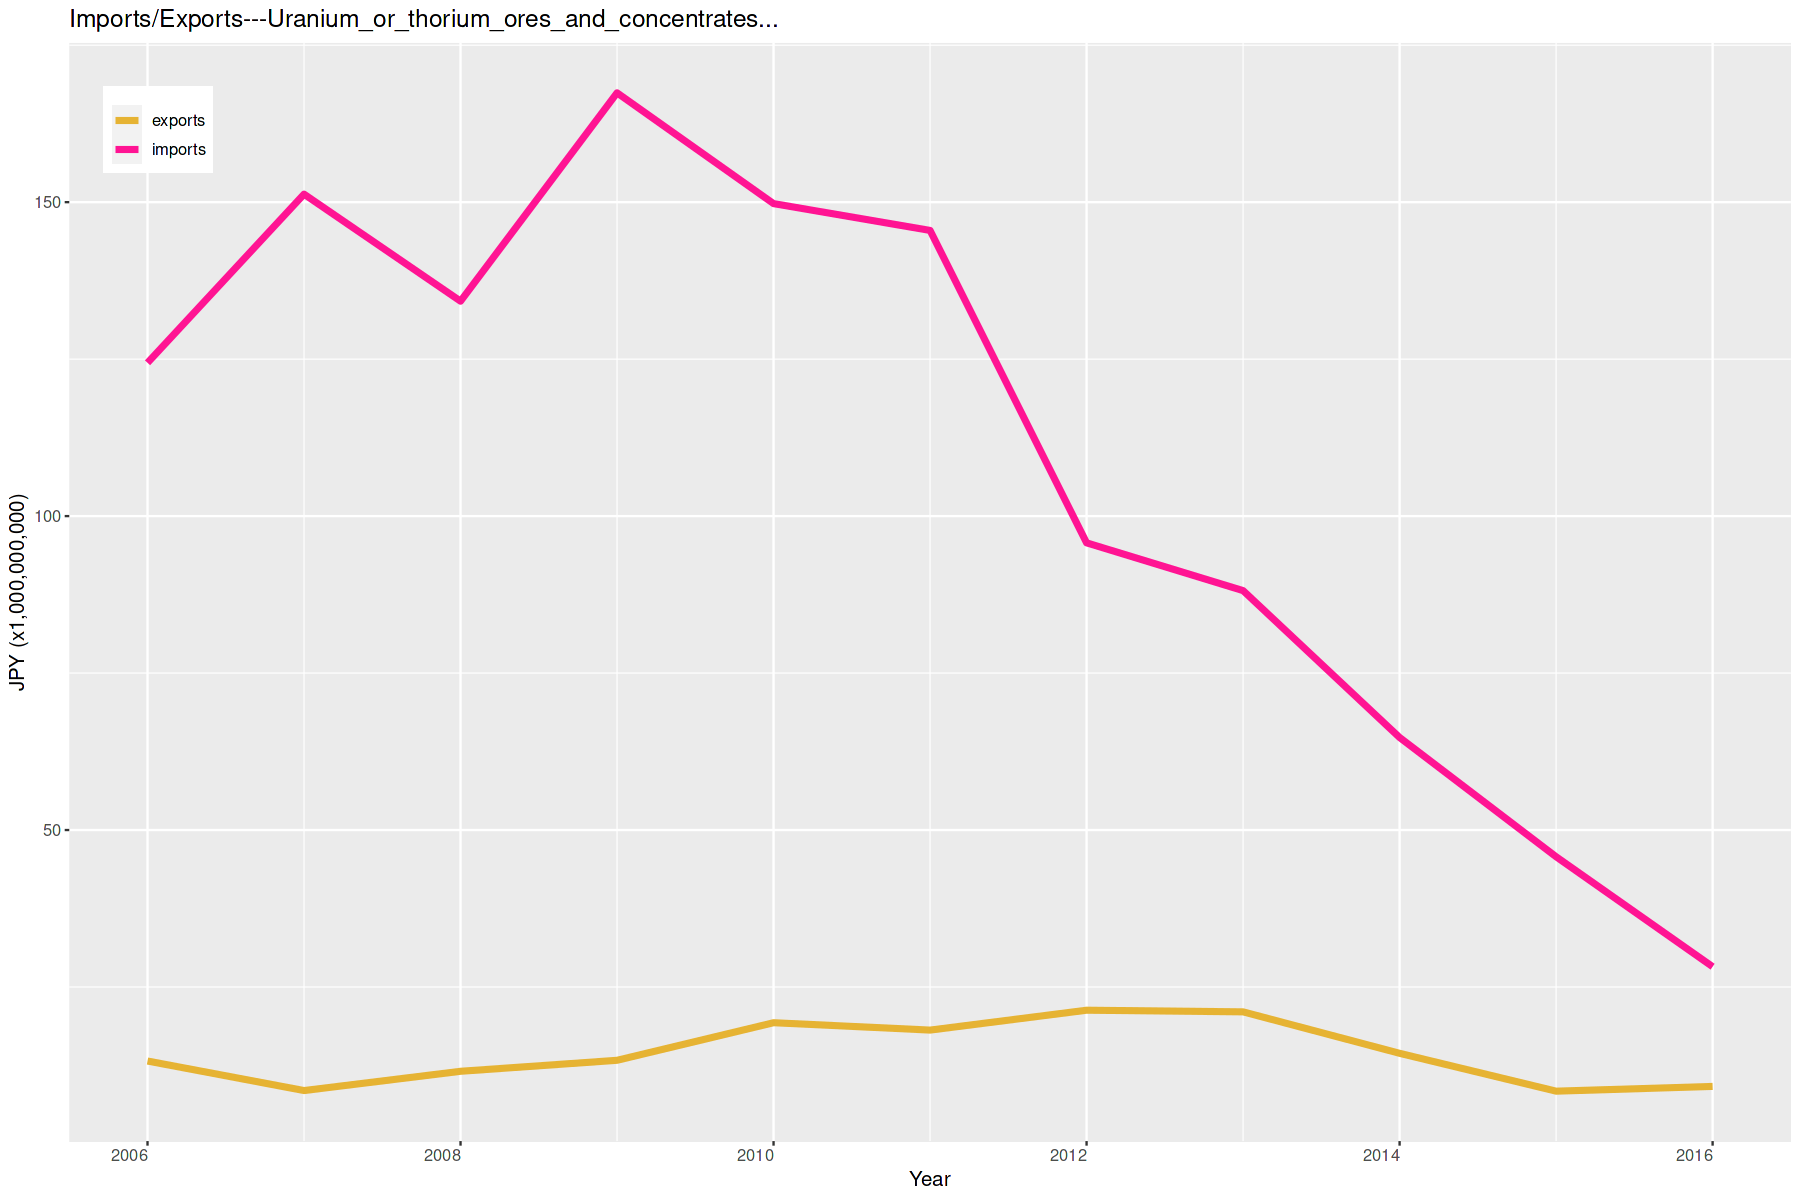

In [79]:
data <- melt(
    setNames(
      data.table(
        nuclearEnergyRelaredTrade[["Value"]], 
        nuclearEnergyRelaredTrade[["Year"]], 
        nuclearEnergyRelaredTrade[["Area"]], 
        nuclearEnergyRelaredTrade[["exp_imp"]]), 
      c("Value", "Year", "Area", "exp_imp")),
    measure.vars = c("Value"), value.name = "Value")

data <- data[Year >= beginYr & Year <= endYr, ]
aggData <- as.data.table(aggregate(Value ~ Year + exp_imp, data = data, FUN = sum))
aggData[, exp_imp := as.factor(exp_imp)]
levels(aggData$exp_imp) <- c("exports", "imports")

factor <- 1000
aggData[, Value := Value / factor]

ggplot(data = aggData,
       aes(x = Year, y = Value, color = exp_imp)) +
  geom_line(size = 1.5) + 
  labs(title = paste0("Imports/Exports---", substr(nuclearEnergyRelaredTrade$hs4_name[1], 1, 80), "..."),
       y = paste0(
         "JPY (x", format(kYenFactor * factor, 
                          nsmall = 0, 
                          big.mark = ",", 
                          digits = 0), ")")) +
  scale_color_manual(values = c("exports" = kColor10, "imports" = kColor17)) +
  theme(text = element_text(size = 12), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY))

# Trades Related to Renewable Energy

In [80]:
hs4RenwableEnergyRelated <- c(8502, 8501, 8482, 7308)

renewableEnergyRelaredTrade <- X[which(X$hs4 %in% hs4RenwableEnergyRelated), ]

# Extract the desired columns and remove duplicates
renewableEnergyRelaredTradeUnique <- unique(renewableEnergyRelaredTrade[, .(hs4, gsub("_", " ", hs4_name))])

# Rename the columns
colNames <- c("HS Code", "Description")
names(renewableEnergyRelaredTradeUnique) <- colNames

# Generate the table as a character string
table_str <- knitr::kable(renewableEnergyRelaredTradeUnique, format = "simple", row.names = FALSE, align = c("l", "l"))

# Display the table
cat(table_str)

HS Code   Description                                                                                                                                                                                                                                                                                                                                                                                                                                 --------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 7308      Structures (excluding prefabricated buildings of heading 94.06) and parts of structures (for example  bridges and 

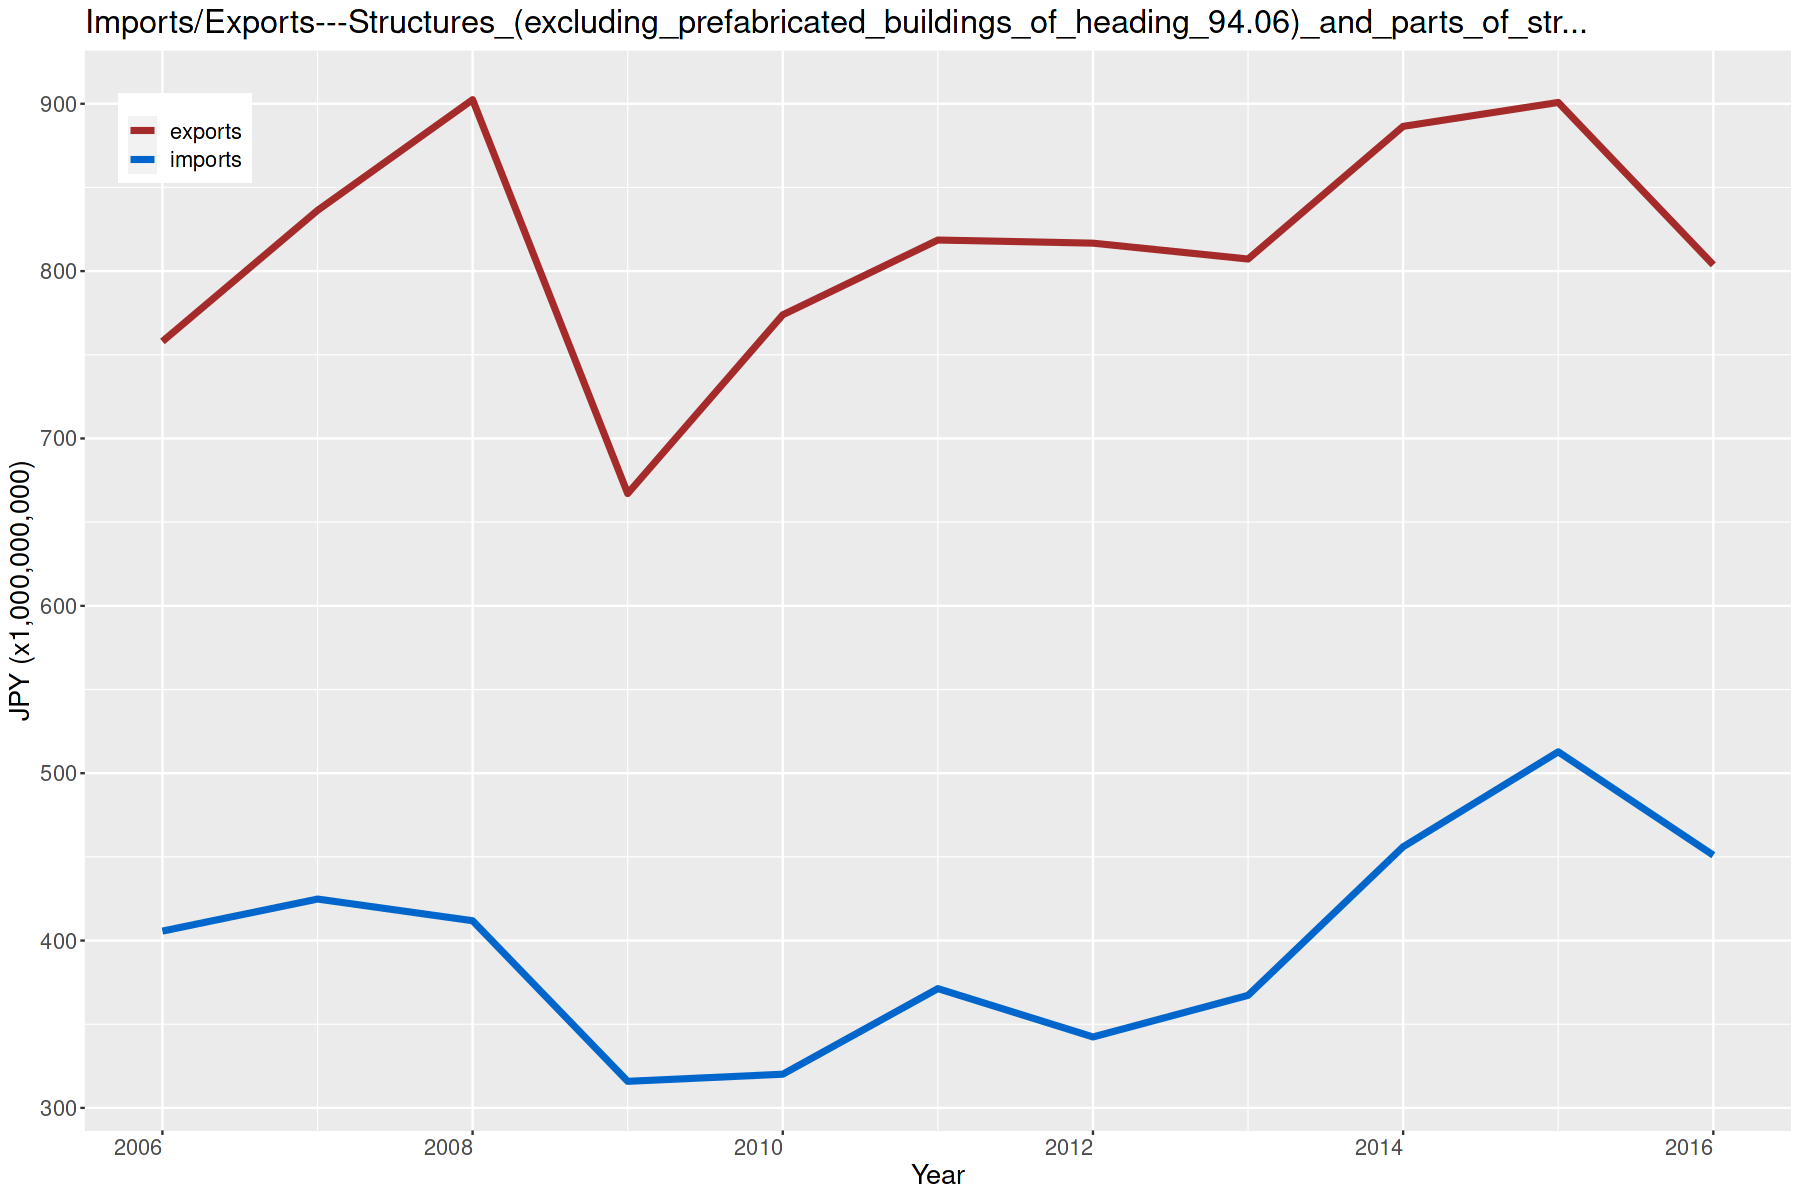

In [93]:
data <- melt(
    setNames(
      data.table(
        renewableEnergyRelaredTrade[["Value"]], 
        renewableEnergyRelaredTrade[["Year"]], 
        renewableEnergyRelaredTrade[["Area"]], 
        renewableEnergyRelaredTrade[["exp_imp"]]), 
      c("Value", "Year", "Area", "exp_imp")),
    measure.vars = c("Value"), value.name = "Value")

data <- data[Year >= beginYr & Year <= endYr, ]
aggData <- as.data.table(aggregate(Value ~ Year + exp_imp, data = data, FUN = sum))
aggData[, exp_imp := as.factor(exp_imp)]
levels(aggData$exp_imp) <- c("exports", "imports")

factor <- 1000
aggData[, Value := Value / factor]

ggplot(data=aggData,
       aes(x = Year, y = Value, color = exp_imp)) +
  geom_line(size = 1.5) + 
  labs(
    title = paste0(
      "Imports/Exports---", 
      substr(renewableEnergyRelaredTrade$hs4_name[1], 1, 80), "..."),
    y = paste0(
      "JPY (x", format(kYenFactor * factor, 
                       nsmall = 0, 
                       big.mark = ",", 
                       digits = 0), ")")) +
  scale_color_manual(values = c("exports" = kColor18, "imports" = kColor15)) +
  theme(text = element_text(size = 16), legend.title =  element_blank(),
        axis.text.x = element_text(angle = 0, hjust = 1), 
        legend.justification = c(0, 1), legend.position = c(kLegPadX, kLegPadY))